# Commodities Derivative Pricing with Multiple Pricing Techniques and Implied Volatility Modelling of Energy and Precious Metals

---
> **Author**: Amos Anderson \
**Program**: Ph.D. student in Applied Mathematics and Statistics (Quantitative Finance Track) and an aspiring Commodities Quant \
**Institution**: Stony Brook University  
**Date**: July 2025

This project presents a comprehensive study on pricing and volatility modelling for crude oil and gold derivatives using analytical, simulation-based, and PDE methods. The goal is to bridge theory with realistic data and modeling tools relevant to the commodities derivatives market.

---

In [245]:
# Necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
from numpy import exp, log, sqrt
import numpy as np
from scipy.optimize import minimize, brentq
from scipy.stats import norm
import os
import requests
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.graph_objects as go
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.integrate import quad


# Setting seed for reproducibility
np.random.seed(123)

## Introduction

Commodities options are amongst the oldest, yet important options in the market. In this project, we focus on two key commodities: crude oil (WTI) and gold, both of which have actively traded spot and futures markets. We collect and preprocess price data that will serve as input to pricing models and volatility surface construction and then price these options using analytical methods, monte carlo simulations, and numerical methods applied to the options pde. We then model and plot the implied volatility surface for each commodity option.

---

## Case Study I: Crude Oil Futures Option Pricing

Futures options are options on futures contracts, where the underlying futures price is typically modeled as a driftless stochastic process. The most common framework for modeling futures price dynamics is to assume that the futures price follows a geometric Brownian motion (GBM) under the risk-neutral measure, as this is standard for pricing derivatives like.  However, there are several other robust pricing frameworks for futures contracts, like the Black-76 model and the Heston Model, that dwells on the GBM price dynamics of futures contracts. We shall explore these pricing techniques. 

> We focus on the pricing of crude oil options, using a range of analytical, simulation-based, and numerical methods. In particular, we use the following pricing techniques:
> - Black-76 Analytical Framework
> - Monte Carlo Simulation under the GBM
> - Monte Carlo Simulation under the Heston Model
> - Finite Difference Method
> - Fast Fourier Transform

We use futures contract prices, market option prices with various strikes on eight futures contracts (from SEP2025 to APR2026), and interpolated risk-free rates from yield curve data , to perform model calibration in order to retrieve implied volatilities, and then compute option prices and compare them against observed market prices from `barchart.com` to evaluate the performance of each pricing technique.

### Market Characteristics of Crude Oil

We consider: 
* Seasonality trends in crude oil demand which affect prices of crude oil futures.
* Structural volatility and event driven spikes
* Contango and Backwardation

We provide plots to visualize seasonality trends in crude oil demand and plot a 30-day annualized volatility of WTI Crude Oil futures prices from 2000 to present, highlighting periods of extreme market turbulence.

#### Seasonality in Demand

Crude oil demand displays strong seasonal patterns, primarily driven by end-use products such as heating oil and gasoline:
- Summer Driving Season: From late spring through early fall, gasoline demand typically rises sharply as personal vehicle usage increases. This elevates refinery activity and supports stronger crude oil prices during these months.
- Winter Heating Season: In colder months, demand for distillate fuels such as heating oil and diesel surges, especially in regions like the U.S. Northeast and Europe. As a result, we often observe a winter premium in heating oil and, indirectly, in crude.

The seasonal patterns of crude oil prices are depicted in the figure below. The graph reveals an upward trend in prices from winter to summer, followed by a decline in the fall.

C:\Users\amosa\AppData\Local\Temp\ipykernel_16092\3649072794.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True



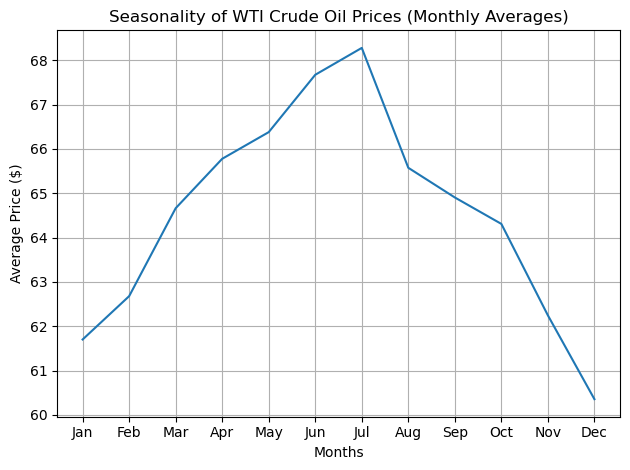

In [201]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download daily WTI front-month futures (CL=F) from Jan 2000 to date
wti_data = yf.download('CL=F',start = "2000-01-01", end = "2025-06-27", progress = False)["Close"]
wti_data = wti_data.rename(columns = {'CL=F': 'Price'})

# Extract month and years from data into separate columns
wti_df = wti_data.reset_index()
wti_df["Month"] = wti_df["Date"].dt.month
wti_df["Year"] = wti_df["Date"].dt.year

# Compute monthly average price per year, then average across years
monthly_avg = wti_df.groupby(["Month","Year"])["Price"].mean().reset_index()
monthly_seasonality = monthly_avg.groupby(["Month"])["Price"].mean()

# Plotting
plt.Figure(figsize = (10,6))
sns.lineplot(x=monthly_seasonality.index, y=monthly_seasonality.values)
plt.title("Seasonality of WTI Crude Oil Prices (Monthly Averages)")
plt.xlabel("Months")
plt.ylabel("Average Price ($)")
plt.xticks(ticks = range(1,13), labels = ["Jan","Feb","Mar","Apr","May","Jun",
                                          "Jul","Aug","Sep","Oct","Nov","Dec"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [202]:
monthly_seasonality

Month
1     61.699575
2     62.677541
3     64.661798
4     65.777228
5     66.378665
6     67.672797
7     68.279528
8     65.574224
9     64.904482
10    64.307881
11    62.244298
12    60.353323
Name: Price, dtype: float64

#### Structural Volatility and Event-Driven Spikes

Unlike many financial assets, crude oil is highly sensitive to geopolitical risks, macroeconomic shocks, and OPEC+ production decisions. These events can lead to sudden and extreme changes in price volatility:
- Geopolitical Events: Conflicts in oil-producing regions (e.g., the Middle East, Russia - Ukraine) frequently introduce large price swings due to fears of supply disruption.
- OPEC+ Policy Decisions: Production quotas and unexpected output cuts or increases by OPEC and its allies often have immediate effects on global oil prices.
- U.S. Inventory Reports: Weekly U.S. crude oil inventory data released by the EIA can move markets significantly, especially when deviations from forecasts occur.

The graph below shows annualized historical volatilities from January 2000 to May 2025, showing four key events that contributed to some volatility spikes within the period. These key events are marked with red dashed vertical lines and labels, including the 2008 financial crisis, 2014 OPEC price war, the unprecedented negative oil prices in April 2020 during COVID-19 demand collapse, and the 2022 price surge following Russia's invasion of Ukraine. 

C:\Users\amosa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



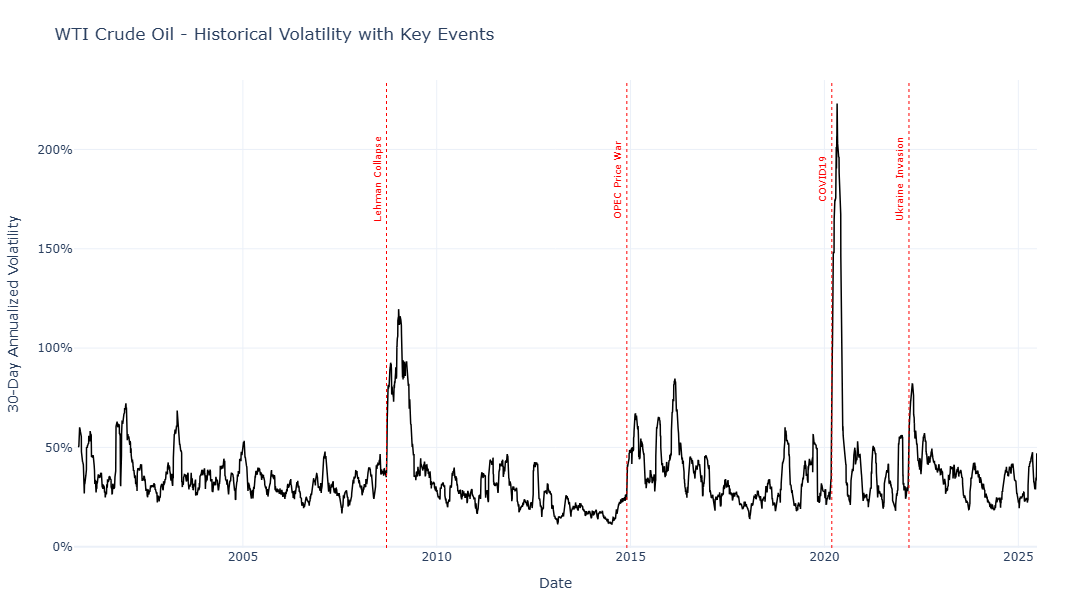

In [203]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Calculate daily log returns
wti_logreturns = np.log(wti_data['Price']/wti_data['Price'].shift(1)).dropna()

# Calculate 30-day rolling annualized volatility (252 trading days/year)
rolling_vol = wti_logreturns.rolling(30).std()*np.sqrt(252)

# Significant events with approximate dates
events = {
    '2008-09-15': 'Lehman Collapse',
    '2014-11-27': 'OPEC Price War',
    '2020-03-11': 'COVID19',
    '2022-03-08': 'Ukraine Invasion'
}

# Create figure
vol_fig = go.Figure()

# Add volatility trace
vol_fig.add_trace(
    go.Scatter(
        x=rolling_vol.index,
        y=rolling_vol,
        mode="lines",
        line=dict(color="black", width=1.5),
        name="30-Day Annualized Volatility",
        hovertemplate="Date: %{x|%b %d, %Y}<br>Volatility: %{y:.1%}<extra></extra>"
    )
)

# Add event markers and annotations
for date, label in events.items():
    event_date = pd.to_datetime(date)
    # Vertical line
    vol_fig.add_vline(
        x=event_date,
        line=dict(color="red", width=1, dash="dot"),
        opacity=1.0
    )
    # Text annotation
    vol_fig.add_annotation(
        x=event_date,
        y=1.8,  # Position above normal volatility range
        text=label,
        showarrow=False,
        xshift=-10,
        yshift=10,
        textangle=-90,
        font=dict(color="red", size=10)
    )

# Update layout
vol_fig.update_layout(
    title="WTI Crude Oil - Historical Volatility with Key Events",
    xaxis_title="Date",
    yaxis_title="30-Day Annualized Volatility",
    yaxis_tickformat=".0%",  # Show as percentage
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=600,
    margin=dict(l=50, r=50, b=50, t=80),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
vol_fig.show()

#### Contango and Backwardation in WTI Futures

The WTI futures curve depicting prices of contracts for delivery at various future dates can exhibit one of two primary structures:
- Contango: A market condition where longer-dated futures are priced higher than near-term contracts. This often occurs when:
	- Inventories are high and storage capacity is not scarce.
	- There is weak immediate demand.
	- Crude is being stockpiled for speculative or strategic reasons.
- Backwardation: A condition where near-term contracts are more expensive than distant contracts. This typically reflects:
	- Tight near-term supply and strong immediate demand.
	- High cost of borrowing or storing crude.
	- Market anticipation of lower future prices.

These structures influence option pricing in several ways. Under contango, futures-based hedging strategies may incur higher carry costs, affecting implied volatilities and the fair value of options. Backwardation may signal scarcity and higher short-term volatility, often resulting in steeper implied volatility skews for short-dated options.

---

### Pricing Data Acquisition and Preparation

#### Data Sources
Three primary data sources are utilized to gather the necessary inputs for pricing crude oil futures options:
- Yahoo Finance: Provides futures contract prices for the eight contracts (SEP2025 to APR2026) as of July 25, 2025. These prices serve as the underlying asset prices for the options.

- Barchart.com: Supplies market prices for options on these futures contracts, including approximately 15 strike prices per contract, along with bid, ask, volume, strike prices, and maturity dates. Some strike prices are consistent across multiple contracts.

- U.S. Treasury Website: Offers yield curve data to interpolate risk-free rates corresponding to each contract’s maturity date, ensuring that the risk-free rate varies appropriately with the time to maturity.

#### Data Preparation

The data from these sources is downloaded separately for each contract and requires consolidation and restructuring for analysis. The following steps outline the data preparation process:

1. Data Consolidation: We combine the datasets from Yahoo Finance and Barchart.com into a single structured dataset. This dataset will include the following columns:

    - Contract: Specifies the futures contract (e.g., SEP2025, OCT2025, ..., APR2026).
      
    - Maturity Date: The expiration date for each futures contract, sourced from `barchart.com`.
  
    - Strike: The strike price for each option, sourced from Barchart.com.
  
    - Price: The mid-price of the option, calculated as the average of the bid and ask prices from `barchart.com`.
      
2. Futures Price: The underlying futures contract price of the options, downloaded from from Yahoo Finance.

3. Risk-Free Rate Interpolation: Using yield curve data from the U.S. Treasury website, we interpolate the risk-free rates for each contract’s maturity date to ensure accurate inputs for the pricing models.

4. Data Organization: We arrange the dataset such that contracts are ordered chronologically from SEP2025 to APR2026, with corresponding strike prices listed in the Strike column. The columns of the dataset we build for this pricing project will have the following columns: \
`Strike`, `Type`,	`Maturity`,	`Tau`,	`Option Price`,	`Contract`,	`Underlying Price` and `RF Rates`

6. Data Validation: Verify the completeness and accuracy of the dataset, checking for missing values, inconsistencies in maturity dates, or outliers in prices.

This structured dataset will serve as the foundation for applying the pricing methodologies, enabling a consistent comparison of computed option prices against the observed market prices from `barchart.com`.

In [145]:
def load_crude_oil_option_data(folder_path, eval_date_str="2025-07-25"):
    """
    Loads and processes crude oil futures option data from Barchart Excel files in the given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the Excel files.
        eval_date_str (str): Evaluation date in 'YYYY-MM-DD' format (e.g., pricing date).
    
    Returns:
        pd.DataFrame: Combined DataFrame with all processed options across maturities.
    """
    all_data = []
    eval_date = datetime.strptime(eval_date_str, "%Y-%m-%d")

    for file in os.listdir(folder_path):
        if file.endswith(".csv") and "options-monthly-options-exp-" in file:
            maturity_str = file.split("options-monthly-options-exp-")[-1].replace(".csv", "")
            maturity_date = datetime.strptime(maturity_str, "%m_%d_%y")
            tau = (maturity_date - eval_date).days / 365.0

            df = pd.read_csv(os.path.join(folder_path, file))

            # Clean up column names just in case
            df.columns = [col.strip() for col in df.columns]

            # Filter to relevant columns
            subset = df[['Strike', 'Type']].copy()

            # Add time to maturity, maturity date, and contract columns
            subset['Maturity'] = maturity_date.strftime("%Y-%m-%d")
            subset['Tau'] = tau
            subset['Option Price'] = ((df['Bid'] + df['Ask']) / 2).astype(float)
            subset['Strike'] = subset['Strike'].str.replace(r'[CP]', '', regex=True).astype(float)
            subset['Type'] = subset['Type'].str.capitalize()  
            subset['Contract'] = file.split("-")[0].upper()

            all_data.append(subset)

    # Concatenate all into one DataFrame
    full_df = pd.concat(all_data, ignore_index=True)

    return full_df

In [147]:
folder_path = "C:/Users/amosa/Documents/My Graduate School/Career Preparation/Quantitative Finance and Development/Projects/Project_1_Commodities Derivatives Pricing with MC and Vol Modelling/data/Crude Oil Data"

crude_data = load_crude_oil_option_data(folder_path, eval_date_str="2025-07-25")
crude_data.to_csv("crude_oil_futures_data.csv", index = False)

In [2]:
true_crude_oil_data = pd.read_csv("crude_oil_futures_data.csv")
true_crude_oil_data

Strike  Type    Maturity       Tau  Option Price Contract
0      49.5  Call  2025-12-16  0.394521        14.570    CLF26
1      51.0  Call  2025-12-16  0.394521        13.275    CLF26
2      51.5  Call  2025-12-16  0.394521        12.855    CLF26
3      54.0  Call  2025-12-16  0.394521        10.830    CLF26
4      55.5  Call  2025-12-16  0.394521         9.675    CLF26
..      ...   ...         ...       ...           ...      ...
475    71.0   Put  2025-11-17  0.315068         9.145    CLZ25
476    71.5   Put  2025-11-17  0.315068         9.535    CLZ25
477    72.0   Put  2025-11-17  0.315068         9.940    CLZ25
478    72.5   Put  2025-11-17  0.315068        10.355    CLZ25
479    73.0   Put  2025-11-17  0.315068        10.770    CLZ25

[480 rows x 6 columns]

In [160]:
# Downloading Yield Data: We will use this data again when pricing gold options
# website for yield data

url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/2025/all?type=daily_treasury_yield_curve&field_tdr_date_value=2025&page&_format=csv"

# Download and save
with open("Treasury_2025.csv", "wb") as f:
    f.write(requests.get(url).content)

In [3]:
# Loading and viewing yield curve data
df_yield = pd.read_csv("Treasury_2025.csv")
df_yield['Date'] = pd.to_datetime(df_yield['Date'])

In [4]:
# Retrieving risk free rates for crude oil option pricing

trade_date_c = '2025-07-25'
# Filter for the desired date
target_date_c = pd.Timestamp(trade_date_c)
target_c = df_yield[df_yield['Date'] == target_date_c]
target_c

Date  1 Mo  1.5 Month  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  \
0 2025-07-25  4.37       4.46  4.46  4.42  4.42  4.31  4.09  3.91  3.86  3.95   

   7 Yr  10 Yr  20 Yr  30 Yr  
0  4.15    4.4   4.92   4.92

In [5]:
# Computing Interpolated yields: Crude Oil trading date

yield_maturities = np.array([1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yield_data_c = np.array([4.37, 4.46, 4.46, 4.42, 4.42, 4.31, 4.09, 3.91, 3.86, 3.95, 4.15, 4.4, 4.92, 4.92]) / 100
yield_range = np.linspace(0.05, 30, 100)

# Computing interpolated yield for each maturity
interpolated_yields_c = interp1d(yield_maturities, yield_data_c, kind='linear', fill_value="extrapolate")

In [6]:
true_crude_oil_data['Underlying Price'] = [yf.download(ticker + '.NYM', start='2025-07-25', end='2025-07-28', auto_adjust=True, progress=False)['Close'].loc[trade_date_c, ticker + '.NYM'] for ticker in true_crude_oil_data['Contract']]
true_crude_oil_data['RF Rates'] = interpolated_yields_c(true_crude_oil_data['Tau'])
true_crude_oil_data.head()

Strike  Type    Maturity       Tau  Option Price Contract  \
0    49.5  Call  2025-12-16  0.394521        14.570    CLF26   
1    51.0  Call  2025-12-16  0.394521        13.275    CLF26   
2    51.5  Call  2025-12-16  0.394521        12.855    CLF26   
3    54.0  Call  2025-12-16  0.394521        10.830    CLF26   
4    55.5  Call  2025-12-16  0.394521         9.675    CLF26   

   Underlying Price  RF Rates  
0         63.080002  0.043796  
1         63.080002  0.043796  
2         63.080002  0.043796  
3         63.080002  0.043796  
4         63.080002  0.043796

In [7]:
true_crude_oil_data.isnull().sum()

Strike              0
Type                0
Maturity            0
Tau                 0
Option Price        0
Contract            0
Underlying Price    0
RF Rates            0
dtype: int64

---

### Analytical Pricing: Black-76 on WTI Futures

Let
$$d_1 = \dfrac{\ln(f_t / K) + \frac{1}{2}\sigma^2}{\sigma \sqrt{T-t}}, \hspace{0.5cm} d_2 = d_1 - \sigma \sqrt{T-t} $$
Then the Black-76 formulas are:
* For Call Option on Futures, $$C(t,f_t) = e^{-r(T-t)}\left[f_{t}\Phi(d_1) - K\Phi(d_2)\right] $$
* For Put Option on Futures,  $$P(t,f_t) = e^{-r(T-t)}\left[ K\Phi(-d_2) - f_{t}\Phi(-d_1) \right] $$
where $\Phi(\cdot )$ is the cumulative distribution function (CDF) of the standard normal distribution.

#### Implied Volatility Callibration
We first calibrate the Black Scholes model to observed market prices given by the column `Option Price` in our market dataset `true_crude_oil_data`. This will help us to find the implied volatility $\sigma = sigma_{\text{imp}}$ corresponding to each underlying price $f_t$ and the market price $C(t,f_t)_{\text{market}}$. Here we made reference to call option price because we can use either call option market price or put option market price to retrieve the implied volatilities. 

In particular, we want to find the roots of the following equation:
$$\sigma_{\text{imp}} : C(t,f_t)_{\text{Market}} - C(t,f_t)_{\text{Black Scholes}} = 0 $$

In Python, `scipy.optimize.brentq` is used to find the root of a single-variable continuous function within a given interval. It implements Brent's method, which is a robust and efficient root-finding algorithm. So we shall use this function to calculate the implied volatilities.

In [8]:
def black76_price(f, K, r, tau, sigma, option_type):
    """
    Calculates the Black-76 model price for European options on futures.

    Parameters:
    f : float
        Futures price
    K : float
        Strike price
    r : float
        Risk-free interest rate
    tau : float
        Time to maturity in years
    sigma : float
        Volatility of futures price
    option_type : str
        'call' or 'put'
    """
    from math import exp, log, sqrt
    from scipy.stats import norm

    if tau <= 0:
        raise ValueError("Time to maturity must be positive. Please calculate (T - t)")

    d1 = (log(f / K) + 0.5 * sigma**2 * tau) / (sigma * sqrt(tau))
    d2 = d1 - sigma * sqrt(tau)

    if option_type.lower() == 'call':
        return exp(-r * tau) * (f * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type.lower() == 'put':
        return exp(-r * tau) * (K * norm.cdf(-d2) - f * norm.cdf(-d1))
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [12]:
# Implied Volatility Solver
def blk76_implied_volatility(market_price, f, K, r, tau, option_type):
    def objective(sigma):
        return black76_price(f, K, r, sigma, tau, option_type) - market_price

    try:
        return brentq(objective, 1e-6, 5.0, maxiter=500)
    except ValueError:
        return np.nan

# Compute IV row-by-row
def compute_blk76_iv(row):
    f = row['Underlying Price']
    K = row['Strike']                  
    r = row['RF Rates']                
    tau = row['Tau']
    option_type = row['Type'].lower()
    market_price = row['Option Price']
    
    return blk76_implied_volatility(market_price, f, K, r, tau, option_type)

# Adding to data
true_crude_oil_data['Model IV'] = true_crude_oil_data.apply(compute_blk76_iv, axis=1)

true_crude_oil_data.head()

Strike  Type    Maturity       Tau  Option Price Contract  \
0    49.5  Call  2025-12-16  0.394521        14.570    CLF26   
1    51.0  Call  2025-12-16  0.394521        13.275    CLF26   
2    51.5  Call  2025-12-16  0.394521        12.855    CLF26   
3    54.0  Call  2025-12-16  0.394521        10.830    CLF26   
4    55.5  Call  2025-12-16  0.394521         9.675    CLF26   

   Underlying Price  RF Rates  Model IV  
0         63.080002  0.043796  0.407567  
1         63.080002  0.043796  0.373496  
2         63.080002  0.043796  0.364351  
3         63.080002  0.043796  0.326344  
4         63.080002  0.043796  0.307021

#### Black 76 Pricing

Next, we use the implied volatilities computed to find the Black-76 model prices for our crude oil option.

In [13]:
# Compute Black 76 model price per row
def compute_blk76_prices(row):
    f = row['Underlying Price']
    K = row['Strike']
    r = row['RF Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    sigma = row['Model IV']
    
    return black76_price(f, K, r, sigma, tau, option_type)

blk76_prices = true_crude_oil_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'Black 76 Price': compute_blk76_prices(row)
    },
    axis=1
)

blk76_prices_df = pd.DataFrame(blk76_prices.tolist())
blk76_prices_df

Strike  Black 76 Price
0      49.5          14.570
1      51.0          13.275
2      51.5          12.855
3      54.0          10.830
4      55.5           9.675
..      ...             ...
475    71.0           9.145
476    71.5           9.535
477    72.0           9.940
478    72.5          10.355
479    73.0          10.770

[480 rows x 2 columns]

---

### Monte Carlo Pricing of WTI Options under Geometric Brownian Motion
Under the risk-neutral measure $\mathbb{Q}$, the GBM process for futures prices is driftless and follows the stochastic differential equation:

\begin{equation}
df_t = \sigma f_t dW_t^\mathbb{Q}
\end{equation}

where: 

* $f_t$ is the underlying futures price at time $t$
* $\sigma$ is the constant volatility
* $W_t^\mathbb{Q}$ is a standard Brownian motion

The closed-form solution of this SDE is:
		$$f_{T} = f_{t}\exp \left \{- \dfrac{1}{2}\sigma^2 (T-t) + \sigma \sqrt{T-t} \cdot Z \right\}, \hspace{0.5cm} $$ where $ Z \sim \mathcal{N}(0,1) $ 

This formula is used to simulate terminal futures prices $f_T$ in a Monte Carlo framework.

The Monte Carlo option price is estimated using discounted payoffs from $N$ simulated paths:
* For a call option,
	$$ C_0 = e^{-r(T-t)} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (f_{T}^{(i)} - K, 0) $$
* For a put option,
	$$ P_0 = e^{-r(T-t)} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (K - f_{T}^{(i)}, 0) $$

In [16]:
# Setting seed for reproducibility
np.random.seed(123)

def monte_carlo_fgbm(f0, K, r, sigma, tau, n_paths, option_type):
    """
    Monte Carlo pricing of a European option on a futures contract under GBM.

    Parameters:
    f0 : float
        Initial futures price at time t = 0. 
    K : float
        Strike price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of futures price
    tau : float
        Time to maturity in years
    n_paths : int
        Number of simulated price paths
    option_type : str
        'call' or 'put'

    Returns:
    price : float
        Monte Carlo estimate of the option price
    mc_gbm_se : float
        Standard error of the Monte Carlo estimate
    """
    
    # Simulate standard normal random variables
    norm_Z = norm.rvs(loc=0, scale=1, size=n_paths)

    # Simulate terminal futures price f_T using GBM solution
    f_T = f0 * np.exp(-0.5 * sigma**2 * tau + sigma * np.sqrt(tau) * norm_Z)
    
    # Compute option payoffs
    if option_type.lower() == 'call':
        payoff = np.maximum(f_T - K, 0)
    elif option_type.lower() == 'put':
        payoff = np.maximum(K - f_T, 0)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    # Discounted average of payoff
    price = np.exp(-r * tau) * np.mean(payoff)

    # Standard error
    disc_payoff = np.exp(-r * tau) * payoff
    mc_gbm_se = np.std(disc_payoff, ddof=1) / np.sqrt(n_paths)

    return price, mc_gbm_se

In [17]:
# Option Constant Parameters
n_paths = 10000
np.random.seed(123)

# Compute Monte Carlo GBM price per row (only once per row)
def compute_monte_carlo_fgbm(row):
    f0 = row['Underlying Price']
    K = row['Strike']
    r = row['RF Rates']
    tau = row['Tau']
    sigma = row['Model IV']
    option_type = row['Type'].lower()

    price, se = monte_carlo_gbm(f0, K, r, sigma, tau, n_paths, option_type)
    return pd.Series({'Strike': K, 'Monte Carlo GBM Price': price, 'Monte Carlo SE': se})

# Apply the function row-wise and collect results efficiently
monte_carlo_fgbm_prices_df = true_crude_oil_data.apply(compute_monte_carlo_fgbm, axis=1)
monte_carlo_fgbm_prices_df

Strike  Monte Carlo GBM Price  Monte Carlo SE
0      49.5              14.758687        0.145817
1      51.0              13.305781        0.133043
2      51.5              12.661901        0.126571
3      54.0              10.552414        0.111126
4      55.5               9.168599        0.101687
..      ...                    ...             ...
475    71.0               8.840312        0.073562
476    71.5               9.281449        0.074414
477    72.0               9.631204        0.076921
478    72.5              10.157657        0.078406
479    73.0              10.462292        0.080055

[480 rows x 3 columns]

---



### Monte Carlo Simulation under Heston Model

Under the risk-neutral measure $\mathbb{Q}$, the Heston model for a futures contract is governed by the following two-dimensional stochastic differential equation (SDE) system:
\begin{align*} 
df_t &= \sqrt{v_t}f_tdW_{t}^{\mathbb{Q},1}, \\
dv_t &= \kappa (\theta - v_t) + \xi \sqrt{v_t}dW_{t}^{\mathbb{Q},2} \\
d\left[W_{t}^{\mathbb{Q},1}, W_{t}^{\mathbb{Q},2}\right]_{t} &= \rho dt
\end{align*}
Where:

- $S_t$ is the spot price of the commodity (like crude oil, gold)
-  $v_t$ is the instantaneous variance, often rendered as $\sigma_{t}^{2}$.
-  $r$ is the risk-free rate.
-  $\kappa$ is the mean reversion speed of variance which measures how fast variance reverts to long-term average.
-  $\theta $ is the long term average variance.
-  $\xi$ is the volatility of the variance process, often called the "volatility of volatility".
-  $\rho $ is the correlation between price and variance shocks.
-  $v_0$ is the initial variance.
-  $W_{t}^{\mathbb{Q},1}, W_{t}^{\mathbb{Q},2}$ are correlated Brownian motions under the risk-neutral measure $\mathbb{Q}$.
-  $r$ is the risk-free rate used only for discounting.

---
#### Discretization using the Euler-Maruyama Scheme

Since the Heston model has no analytical solution, we apply the Euler-Maruyama method. Given a time grid with uniform step size $\Delta t = \frac{T}{N}$, the discrete dynamics for each Monte Carlo path are:
\begin{align*}
\Delta W_t^{(1)} &= Z_1 \sqrt{\Delta t}, \quad Z_1 \sim \mathcal{N}(0, 1), \\
\Delta W_t^{(2)} &= \rho Z_1 \sqrt{\Delta t} + \sqrt{1 - \rho^2} Z_2 \sqrt{\Delta t}, \quad Z_2 \sim \mathcal{N}(0, 1), \\
v_{t+\Delta t} &= v_t + \kappa(\theta - v_t)\Delta t + \xi \sqrt{v_t} \Delta W_t^{(2)}, \\
f_{t+\Delta t} &= f_t \cdot \exp\left[- \frac{1}{2}v_t\Delta t + \sqrt{v_t} \Delta W_t^{(1)}\right].
\end{align*}

Here, $f_t$ is the futures price, $v_t$ is the instantaneous variance, and the Brownian motions driving the price and variance processes are correlated with coefficient $\rho$. We apply the above Euler-Maruyama scheme, but with Full Truncation, that is for each $v_t$, we take $v_t \leftarrow \max(v_t, 0)$, which is the preferred method for Heston simulations due to its numerical stability and preservation of the Feller condition even when violated. 

---
#### Heston Model Calibration using Monte Carlo Simulation

The goal of calibrating the Heston model is to find a set of model parameters — initial variance $ v_0 $, mean reversion speed $ \kappa $, long-run variance $ \theta $, volatility of volatility $ \xi $, and correlation $ \rho $ — that best explain the observed market prices of options. This calibration process ensures that the stochastic volatility dynamics modeled by the Heston framework align with market-implied information, allowing us to use the model for pricing, hedging, and risk management with greater accuracy.

We achieve calibration by defining a loss function that compares model prices (generated via Monte Carlo simulation of the Heston model) to observed market prices. A common choice is the Root Mean Squared Error (RMSE). We then use a numerical optimization routine (such as `scipy.optimize.minimize`) to find the parameter set that minimizes this RMSE, subject to reasonable bounds for each parameter to maintain model stability and realism. Once optimal parameters are found, they can be used to compute consistent and arbitrage-free prices for other option contracts.

In [45]:
def monte_carlo_heston_EulerMaruyama_fut(f0, v0, r, K, tau, rho, kappa, theta, xi, n_steps, n_paths, option_type):
    delta_t = tau / n_steps
    v = np.zeros((n_paths, n_steps + 1))
    futures = np.zeros((n_paths, n_steps + 1))
    v[:, 0], futures[:, 0] = v0, f0
    z1 = np.random.normal(0, 1, (n_paths, n_steps))
    z2 = np.random.normal(0, 1, (n_paths, n_steps))
    delta_w1 = z1 * np.sqrt(delta_t)
    delta_w2 = rho * z1 * np.sqrt(delta_t) + np.sqrt(1 - rho**2) * z2 * np.sqrt(delta_t)
    
    for t in range(n_steps):
        v[:, t + 1] = v[:, t] + kappa * (theta - np.maximum(v[:, t], 0)) * delta_t + xi * np.sqrt(np.maximum(v[:, t], 1e-6)) * delta_w2[:, t]
        v[:, t + 1] = np.maximum(v[:, t + 1], 0)
        futures[:, t + 1] = futures[:, t] * np.exp(-0.5 * np.maximum(v[:, t], 0) * delta_t + np.sqrt(np.maximum(v[:, t], 1e-6)) * delta_w1[:, t])
    
    terminal_prices = futures[:, -1]
    payoff = np.maximum(terminal_prices - K, 0) if option_type.lower() == 'call' else np.maximum(K - terminal_prices, 0)
    option_prices = np.exp(-r * tau) * np.mean(payoff)
    return option_prices

In [64]:
def batch_monte_carlo_heston(group_data, v0, rho, kappa, theta, xi, n_steps, n_paths):
    f0 = group_data['Underlying Price'].iloc[0]
    r = group_data['RF Rates'].iloc[0]
    tau = group_data['Tau'].iloc[0]
    K = group_data['Strike'].values
    option_type = group_data['Type'].values
    delta_t = tau / n_steps
    v = np.zeros((n_paths, n_steps + 1))
    futures = np.zeros((n_paths, n_steps + 1))
    v[:, 0], futures[:, 0] = v0, f0
    z1 = np.random.normal(0, 1, (n_paths, n_steps))
    z2 = np.random.normal(0, 1, (n_paths, n_steps))
    delta_w1 = z1 * np.sqrt(delta_t)
    delta_w2 = rho * z1 * np.sqrt(delta_t) + np.sqrt(1 - rho**2) * z2 * np.sqrt(delta_t)
    
    for t in range(n_steps):
        v[:, t + 1] = v[:, t] + kappa * (theta - np.maximum(v[:, t], 0)) * delta_t + xi * np.sqrt(np.maximum(v[:, t], 0)) * delta_w2[:, t]
        v[:, t + 1] = np.maximum(v[:, t + 1], 0)
        futures[:, t + 1] = futures[:, t] * np.exp(-0.5 * np.maximum(v[:, t], 0) * delta_t + np.sqrt(np.maximum(v[:, t], 0)) * delta_w1[:, t])
    
    terminal_prices = futures[:, -1]
    model_prices = []
    for k, opt_type in zip(K, option_type):
        if opt_type.lower() == 'call':
            payoff = np.maximum(terminal_prices - k, 0)
        elif opt_type.lower() == 'put':
            payoff = np.maximum(k - terminal_prices, 0)
        else:
            raise ValueError("Option type must be 'call' or 'put' ")
            
        model_prices.append(np.exp(-r * tau) * np.mean(payoff))
    return model_prices

In [76]:
def heston_model_calibration_fut(true_crude_oil_data, n_steps, n_paths):
    def objective(params):
        v0, kappa, theta, xi, rho = params
        squared_errors = []
        for _, group in true_crude_oil_data.groupby(['Contract', 'Maturity']):
            model_prices = batch_monte_carlo_heston(group, v0, rho, kappa, theta, xi, n_steps, n_paths)
            squared_errors.extend((group['Option Price'].values - model_prices) ** 2)
        return np.sqrt(np.mean(squared_errors))
    
    initial_params = [0.05, 1.0, 0.04, 0.5, -0.6]
    bounds = [(1e-5, 1.0), (0.5, 5.0), (1e-5, 1.0), (0.1, 1.0), (-0.999, 0.999)]
    result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')
    
    v0, kappa, theta, xi, rho = result.x
    return {
        'v0': v0,
        'kappa': kappa,
        'theta': theta,
        'xi': xi,
        'rho': rho,
        'Minimum loss': result.fun
    }

In [77]:
# Inputs
n_steps = 250  
n_paths = 10000 
calibration_result_fut = heston_model_calibration_fut(true_crude_oil_data, n_steps, n_paths)
calibration_result_fut

{'v0': np.float64(0.04999999641476838),
 'kappa': np.float64(0.9999999641405118),
 'theta': np.float64(0.039999997131958134),
 'xi': np.float64(0.4999999713124095),
 'rho': np.float64(-0.6000000286158715),
 'Minimum loss': np.float64(1.1524356269231473)}

#### Monte Carlo Pricing of WTI under Heston Model

In [75]:
v0 = calibration_result_fut['v0']
kappa = calibration_result_fut['kappa']
theta = calibration_result_fut['theta']
xi = calibration_result_fut['xi']
rho = calibration_result_fut['rho']

n_steps = 250
n_paths = 10000

heston_monte_carlo_fut_prices = batch_monte_carlo_heston(true_crude_oil_data, v0, rho, kappa, theta, xi, n_steps, n_paths)
heston_monte_carlo_fut_df = pd.DataFrame({
    'Strike' : K,
    'MC Heston Prices' : heston_monte_carlo_fut_prices
})
heston_monte_carlo_fut_df

Strike  MC Heston Prices
0      49.5         13.778875
1      51.0         12.415562
2      51.5         11.967737
3      54.0          9.791420
4      55.5          8.542940
..      ...               ...
475    71.0          8.344430
476    71.5          8.761398
477    72.0          9.186087
478    72.5          9.618254
479    73.0         10.057174

[480 rows x 2 columns]

---
### Finite Difference Pricing of WTI Crude Oil Futures Options

Next,  we implement a Finite Difference Method (FDM) for pricing European-style options written on WTI crude oil futures contracts. Specifically, we solve the driftless Black-76 model PDE using the Crank–Nicolson method, a time-centered scheme known for its numerical stability and second-order accuracy in both time and space.

Given the structure of WTI futures and the fact that the futures price under risk-neutral measure is a martingale, we work with the driftless Black–Scholes PDE, which governs the evolution of the option price with respect to the futures price as the underlying.

The full Crank Nicolson algorithm, which will be implemented, proceeds in three main stages follows:
1. Set terminal values using the payoff

2. For each time level, moving backwards:

    - enforce boundary conditions on $V$
    - solve the tridiagonal system for interior points
    - update the solution

3. Interpolate the solution at  (the actual observed futures price) to report the option value.

Next, we discuss the above algorithm in detail.

#### Black-76 PDE
Let $f_{t}$ be the price of the WTI crude oil futures at time $t$, and let $V(f,t)$ be the real time value of a European call option on the futures.

Under the risk-neutral measure, the arbitrage-free price of the European option on futures satisfies the following PDE:
$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0 $$

with the terminal condition:
\begin{align}
V(f,t) = f(x) = \begin{cases}
    \max(f_T - K, 0) & \text{if } \text{Call} \\
    \max(K - f_T, 0) & \text{if } \text{Put} \\
\end{cases}
\end{align}

where 
- $f$: Underlying futures price of WTI crude oil.
- $V(f,t)$: WTI crude oil option price at time $t$
- $\sigma $: Volatility of WTI crude oil option price
- $r$ : Risk-free rate
- $K$ : Strike Price of option

#### Descritization Process
Let $f_{\min}$ and $f_{\max}$ denote the minimum and maximum futures prices on the grid and define:
- $M$ as the number of futures price steps and $N$ as the number of time steps such that
$$ \Delta f = \dfrac{ f_{\max } - f_{\min } }{M}, \quad \Delta t = \dfrac{T}{N}$$
The futures price grid is constructed to have the values:
$$f_0, f_1, \ldots, f_M $$
while the time grid has:
$$t_0, t_1, \ldots, t_N = T $$
moving backwards in time from $T$ to 0.

#### Coefficient Vectors
For the Crank–Nicolson scheme, interior grid points $i=1,2,\ldots, M-1$ use
\begin{align}
a_i &= \frac{1}{4}\Delta t \left(\sigma^2 \frac{f_{i}^2 }{ \Delta f^2} \right) \\
b_i &= -\frac{1}{2}\Delta t \left(\sigma^2 \frac{ f_{i}^2 }{\Delta f^2} + r \right)   \\
c_i &= \frac{1}{4}\Delta t \left(\sigma^2 \frac{f_{i}^2 }{ \Delta f^2} \right)
\end{align}
These define the three-diagonal system at each timestep.

#### Implicit and Explicit Matrices
The Crank–Nicolson method blends implicit and explicit updates by forming:
$$
A = I + 
\begin{bmatrix}
b_1 & c_1 &        &        &        \\
a_2 & b_2 & c_2    &        &        \\
    & a_3 & b_3    & \ddots &        \\
    &     & \ddots & \ddots & c_{M-2} \\
    &     &        & a_{M-1} & b_{M-1}
\end{bmatrix}
$$
and
$$
B = I - 
\begin{bmatrix}
b_1 & c_1 &        &        &        \\
a_2 & b_2 & c_2    &        &        \\
    & a_3 & b_3    & \ddots &        \\
    &     & \ddots & \ddots & c_{M-2} \\
    &     &        & a_{M-1} & b_{M-1}
\end{bmatrix}
$$

Hence, at each time step, we solve:
$$A \cdot V^n = B \cdot V^{n+1}$$
where $V^n$ is the vector of prices at the previous time level. These are tridiagonal and can be efficiently solved by the Thomas algorithm.

#### Boundary Conditions
The boundary conditions reflect the limiting behavior:
- Call option:
    $$V(f_{\min }, t) = 0, \quad V(f_{\max }, t) = f_{\max } - Ke^{-r(T - t)}$$
- Put option:
  $$V(f_{\min }, t) =  Ke^{-r(T - t)} - f_{\min }, \quad V(f_{\max }, t) = 0 $$

#### Interpolating the Results
Once the PDE solution is marched to time zero, we extract the option price corresponding to the initial futures price. This is typically performed with linear interpolation across the price grid using `scipy.interpolate.interp1d`.

In [90]:
true_crude_oil_data

Strike  Type    Maturity       Tau  Option Price Contract  \
0      49.5  Call  2025-12-16  0.394521        14.570    CLF26   
1      51.0  Call  2025-12-16  0.394521        13.275    CLF26   
2      51.5  Call  2025-12-16  0.394521        12.855    CLF26   
3      54.0  Call  2025-12-16  0.394521        10.830    CLF26   
4      55.5  Call  2025-12-16  0.394521         9.675    CLF26   
..      ...   ...         ...       ...           ...      ...   
475    71.0   Put  2025-11-17  0.315068         9.145    CLZ25   
476    71.5   Put  2025-11-17  0.315068         9.535    CLZ25   
477    72.0   Put  2025-11-17  0.315068         9.940    CLZ25   
478    72.5   Put  2025-11-17  0.315068        10.355    CLZ25   
479    73.0   Put  2025-11-17  0.315068        10.770    CLZ25   

     Underlying Price  RF Rates  Model IV  
0           63.080002  0.043796  0.407567  
1           63.080002  0.043796  0.373496  
2           63.080002  0.043796  0.364351  
3           63.080002  0.043796  0.326344  
4           63.080002  0.043796  0.307021  
..                ...       ...       ...  
475         63.320000  0.044200  0.271249  
476         63.320000  0.044200  0.271333  
477         63.320000  0.044200  0.273073  
478         63.320000  0.044200  0.275754  
479         63.320000  0.044200  0.277562  

[480 rows x 9 columns]

In [149]:
def crank_nicolson_fdm_wti(f0, K, r, tau, sigma, f_max, f_min, n_steps, m_steps, option_type):
    """
    Solves the Black-76 PDE using the Crank-Nicolson finite difference method.

    Parameters:
    f0 : float
        Current futures price.
    K : float
        Strike price.
    r : float
        Risk-free interest rate.
    tau : float
        Time to maturity.
    sigma : float
        Volatility of futures price.
    f_max : float
        Upper bound for the futures price grid.
    f_min : float
        Lower bound for the futures price grid (usually 0).
    n_steps : int
        Number of time steps.
    m_steps : int
        Number of price steps in the grid.
    option_type : str
        'call' or 'put'

    Returns:
    float
        Option price at time 0 for futures price f0.
    """

    # Discretization
    f_min = np.maximum(f_min, 1e-6)
    delta_f = (f_max - f_min) / m_steps
    delta_t = tau / n_steps
    f_grid = np.linspace(f_min, f_max, m_steps + 1)

    # Terminal condition: Payoff at maturity
    if option_type.lower() == 'call':
        V = np.maximum(f_grid - K, 0)
    elif option_type.lower() == 'put':
        V = np.maximum(K - f_grid, 0)
    else:
        raise ValueError("Option type must be either 'call' or 'put'")

    # Internal grid points (excluding boundaries)
    i = np.arange(1, m_steps)
    f_i = f_grid[i]

    # Crank-Nicolson coefficients for Black-76 PDE 
    a = 0.25 * delta_t * sigma**2 * f_i**2 / delta_f**2
    b = 0.5 * delta_t * (sigma**2 * f_i**2 / delta_f**2 + r)
    c = 0.25 * delta_t * sigma**2 * f_i**2 / delta_f**2

    # Construct matrices A (implicit) and B (explicit)
    A = diags(
        diagonals=[-a[1:], 1 + b, -c[:-1]],
        offsets=[-1, 0, 1],
        shape=(m_steps - 1, m_steps - 1),
        format='csc'
    )

    B = diags(
        diagonals=[a[1:], 1 - b, c[:-1]],
        offsets=[-1, 0, 1],
        shape=(m_steps - 1, m_steps - 1),
        format='csc'
    )

    # Time-stepping
    for n in reversed(range(n_steps)):
        t = n * delta_t
        RHS = B @ V[1:m_steps]
        V[1:m_steps] = spsolve(A, RHS)

        # Boundary conditions
        if option_type.lower() == 'call':
            V[0] = 0
            V[-1] = f_max - K * np.exp(-r * (tau - t))
        else:
            V[0] = K * np.exp(-r * (tau - t)) - f_min
            V[-1] = 0

    # Interpolate to get price at f0
    interpolator = interp1d(f_grid, V, kind='linear', fill_value='extrapolate')
    price_at_f0 = interpolator(f0)

    return float(price_at_f0)

In [156]:
true_crude_oil_data['Underlying Price'].max() * np.exp(3 * max_sigma * np.sqrt(max_tau))

np.float64(1237734.4209305714)

In [158]:
max_sigma = true_crude_oil_data['Model IV'].max()
max_tau = true_crude_oil_data['Tau'].max()
f_max = 3 * true_crude_oil_data['Underlying Price'].max() #* np.exp(3 * max_sigma * np.sqrt(max_tau))

n_steps = 150
m_steps = 2000

# Compute FDM price per row
def compute_fdm_fut(row):
    f0 = row['Underlying Price']
    K = row['Strike']
    r = row['RF Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    sigma = row['Model IV']
    
    return crank_nicolson_fdm_wti(f0, K, r, tau, sigma, f_max, f_min, n_steps, m_steps, option_type)

fdm_prices_fut = true_crude_oil_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'FDM Price': round(compute_fdm_fut(row), 2)
    },
    axis=1
)

fdm_prices_df_fut = pd.DataFrame(fdm_prices_fut.tolist())
fdm_prices_df_fut

C:\Users\amosa\AppData\Local\Temp\ipykernel_16092\1412086364.py:74: MatrixRankWarning: Matrix is exactly singular
  V[1:m_steps] = spsolve(A, RHS)


Strike  FDM Price
0      49.5      14.63
1      51.0      13.17
2      51.5      12.70
3      54.0      10.44
4      55.5       9.15
..      ...        ...
475    71.0       8.89
476    71.5       9.28
477    72.0       9.70
478    72.5      10.14
479    73.0      10.57

[480 rows x 2 columns]

---
### Carr-Madan Fast Fourier Transform (FFT) Method for WTI Futures Option Pricing under the Heston Model

We now present the application of the Fast Fourier Transform (Carr & Madan, 1999) for pricing European options on WTI futures, under the Heston stochastic volatility model. Unlike spot assets, the futures price under risk-neutral measure follows a driftless stochastic differential equation, which simplifies the form of the characteristic function.

We proceed in three steps:

- Heston Model Setup for Futures

- Characteristic Function of $\log F_T$

- Carr-Madan FFT Pricing Method

---
#### Heston Model for Futures
Let $F_t$ denote the futures price at time $t$. Under the risk-neutral measure $\mathbb{Q}$, the Heston model dynamics for the futures price $F_t$ and its variance $v_t$ are given by:

\begin{align}
dF_t &= \sqrt{v_t} f_t , dW_t^f \\
dv_t &= \kappa(\theta - v_t), dt + \xi \sqrt{v_t}, dW_t^v
\end{align}

with instantaneous correlation $\mathbb{E}[dW_t^f dW_t^v] = \rho dt$.

This formulation is driftless because futures prices are already martingales under $\mathbb{Q}$ (by definition of the futures market), and hence, there is no risk-free rate $r$ in the drift term of $f_t$.

---
#### Characteristic Function of $\log F_T$ under Heston Model
Let $\phi \in \mathbb{R}$ be the Fourier integration variable and $\tau = T - t$ be the time to maturity. 

Define:

- $\Theta = (v_0, \kappa, \theta, \xi, \rho)$ as the set of Heston parameters,

- $v_0$ the initial variance,

- $f_0$ the current futures price.

The risk-neutral characteristic function of $\log f_T$ is of log-affine form:

\begin{align}
f(\phi; \Theta ) = \mathbb{E}^{\mathbb{Q}}\left[e^{i\phi \log f_T }\right] = \exp\left(i\phi \log f_0 + C(\tau, \phi) + D(\tau, \phi) v_0 \right)
\end{align}

We define intermediate terms:

\begin{align}
a &= \kappa \theta, \quad
b = \kappa - \rho \xi, \quad
i = \sqrt{-1}
\end{align}

\begin{align}
d(\phi) &= \sqrt{(\rho \xi i \phi - b)^2 + \xi^2 (\phi^2 + i\phi)} \\
g(\phi) &= \frac{b - \rho \xi i \phi + d(\phi)}{b - \rho \xi i \phi - d(\phi)}
\end{align}

Then the coefficients $C(\tau, \phi)$ and $D(\tau, \phi)$ are:

\begin{align}
C(\tau, \phi) &= \frac{a}{\xi^2} \left[(b - \rho \xi i \phi + d(\phi))\tau - 2 \ln \left(\frac{1 - g(\phi) e^{d(\phi) \tau}}{1 - g(\phi)} \right) \right] \\
D(\tau, \phi) &= \frac{ b - \rho \xi i \phi + d(\phi)}{\xi^2 }\left(\frac{1 - e^{d(\phi) \tau}}{1 - g(\phi) e^{d(\phi) \tau}}\right)
\end{align}

---
#### Carr-Madan FFT Pricing Framework (Futures)
To recover the option price $C(K)$ from its Fourier representation, Carr & Madan proposed damping the price with an exponential factor to ensure integrability.

Let $\alpha > 0$ be the damping parameter. Define the damped call price:

\begin{align}
\tilde{C}(K) = e^{\alpha \log K} C(K)
\end{align}

Then the Fourier transform of $\tilde{C}$ is:

\begin{align}
\psi(\phi) = \int_{0}^{\infty} e^{i\phi \log K} \tilde{C}(K), d \log K
\end{align}

Carr and Madan show that this transform can be expressed directly in terms of the Heston characteristic function:

\begin{align}
\psi(\phi) = \frac{f(\phi - i(\alpha + 1); \Theta)}{\alpha^2 + \alpha - \phi^2 + i(2\alpha + 1)\phi}
\end{align}

> Note: There is no $e^{-r\tau}$ discounting factor, as futures prices already incorporate the risk-free rate.

---
#### Recovering the Call Price
The undamped call price $C(K)$ is then recovered via the inverse Fourier transform:

\begin{align}
C(K) = \frac{\exp(-\alpha \log K)}{\pi } \int_{0}^{\infty} \Re \left[e^{i\phi \log K } \psi(\phi) \right] d\phi
\end{align}

This integral is computed numerically via the Fast Fourier Transform (FFT).

---
#### Numerical Implementation
The FFT discretization involves defining a uniform Fourier grid:

- Let $N$ be the number of points (typically a power of 2).

- Let $\eta$ be the spacing in Fourier domain: $\phi_j = j \eta$.

- The corresponding log-strike spacing is $\Delta k = \frac{2\pi}{N \eta}$.

- Let $b = \frac{N \Delta k}{2}$ be the center of the log-strike grid.

- Define log-strikes $k_j = -b + j \Delta k$, so that strikes are $K_j = e^{k_j}$.

The resulting FFT computation returns call prices $C(K_j)$ for all $j$ simultaneously.

---
#### Calibration of Heston Parameters via FFT on Futures Options

To calibrate the Heston model parameters for futures options, we adopt the following procedure:

1. **Initial Guess and Bounds:**
   Begin with a reasonable initial guess $\Theta_0 = (v_0, \kappa, \theta, \xi, \rho)$ and define parameter bounds to ensure admissibility.

2. **Optimal Damping $\alpha$:**
   Select the damping factor $\alpha$ that minimizes pricing error over a candidate grid (e.g., $\alpha \in [1.0, 2.0]$). The error metric is:
   $$
   \text{MSE}_\alpha = \frac{1}{n} \sum_{j=1}^n \left(\frac{C^{\text{market}}_j - C^{\text{model}}_j(\alpha)}{\epsilon_j}\right)^2
   $$

3. **Objective Function:**
   Minimize the mean squared pricing error:
   $$
   \min_{\Theta} \frac{1}{n} \sum_{j=1}^n \left(\frac{C^{\text{market}}_j - C^{\text{model}}_j(\Theta)}{C^{\text{market}}_j + \epsilon}\right)^2
   $$

4. **Optimization Algorithm:**
   Use gradient-based methods (e.g., L-BFGS-B) subject to parameter bounds.

The result is a calibrated parameter set $\hat{\Theta}$ and optimal $\alpha$ that can be used to price options and compute implied volatilities.


In [179]:
def fft_carr_madan_futures_price(f0, K, r, v0, tau, rho, kappa, theta, xi, alpha, option_type):
    """
    Vectorized FFT-based option pricing for futures under the Heston model.
    
    Parameters:
    - f0: float, futures price
    - K: array, strike prices
    - r: float, risk-free rate
    - tau: float, time to maturity
    - v0, rho, kappa, theta, xi: Heston parameters
    - alpha: float, damping parameter
    - option_type: array, 'call' or 'put'
    
    Returns:
    - array of option prices
    """
    N = 4096
    eta = 0.25
    delta_k = 2 * np.pi / (N * eta)
    b_c = N * delta_k / 2
    j = np.arange(N)
    phi_j = j * eta
    k_j = -b_c + j * delta_k

    def heston_cf(phi):
        i = 1j
        a = kappa * theta
        b = kappa - rho * xi * i * phi
        d = np.sqrt((rho * xi * i * phi - b)**2 + xi**2 * (i * phi + phi**2))
        g = (b - rho * xi * i * phi + d) / (b - rho * xi * i * phi - d)
        C = r * i * phi * tau + (a / xi**2) * ((b - rho * xi * i * phi + d) * tau - 
                                             2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
        D = (b - rho * xi * i * phi + d) / xi**2 * (1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau))
        return np.exp(C + D * v0 + i * phi * np.log(f0))

    def carr_madan_integrand(phi):
        i = 1j
        cf_val = heston_cf(phi - i * (alpha + 1))
        numerator = np.exp(-r * tau) * cf_val  # Discounting
        denominator = alpha**2 + alpha - phi**2 + i * (2 * alpha + 1) * phi
        return numerator / denominator

    # Simpson weights
    w_j = np.ones(N)
    w_j[1:N-1:2] = 4
    w_j[2:N-2:2] = 2
    w_j *= eta / 3

    psi_phi = carr_madan_integrand(phi_j)
    integrand = np.exp(-1j * phi_j * b_c) * psi_phi * w_j
    fft_output = np.fft.fft(integrand).real
    call_prices = np.exp(-alpha * k_j) / np.pi * fft_output

    # Interpolate for all strikes
    k_targets = np.log(K)
    interpolator = interp1d(k_j, call_prices, kind='cubic', bounds_error=False, fill_value='extrapolate')
    prices = interpolator(k_targets)

    # Adjust for puts
    if isinstance(option_type, str):
        if option_type.lower() == 'call':
            return prices
        elif option_type.lower() == 'put':
            return (prices - f0 + K * np.exp(-r * tau))
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    else:
        is_call = np.array([opt.lower() == 'call' for opt in option_type])
        return np.where(is_call, prices, prices - f0 + K * np.exp(-r * tau))

In [180]:
def find_optimal_alpha(group_data, heston_params, n_steps=4096, eta=0.25):
    """
    Find optimal damping parameter alpha for a group of options (same Contract, Maturity).
    
    Parameters:
    - group_data: DataFrame with columns ['Underlying Price', 'Strike', 'RF Rates', 'Tau', 'Option Price', 'Type']
    - heston_params: list [v0, kappa, theta, xi, rho]
    - n_steps: int, FFT grid size
    - eta: float, frequency spacing
    
    Returns:
    - float, optimal alpha
    """
    alpha_grid = np.linspace(1.0, 2.0, 10)  # Wider grid for robustness
    v0, kappa, theta, xi, rho = heston_params
    f0 = group_data['Underlying Price'].iloc[0]
    r = group_data['RF Rates'].iloc[0]
    tau = group_data['Tau'].iloc[0]
    K = group_data['Strike'].values
    market_prices = group_data['Option Price'].values
    option_type = group_data['Type'].values
    
    mse_list = []
    for alpha_val in alpha_grid:
        model_prices = fft_carr_madan_futures_price(f0, K, r, v0, tau, rho, kappa, theta, xi, alpha_val, option_type)
        errors = (market_prices - model_prices) ** 2 / np.maximum(1e-6, 0.01 * market_prices)
        mse_list.append(np.mean(errors))
    
    best_alpha = alpha_grid[np.argmin(mse_list)]

    return best_alpha

In [181]:
def calibrate_heston_fft_futures(true_crude_oil_data, n_steps=4096, eta=0.25):
    """
    Calibrate Heston model parameters to market futures option prices using FFT.
    
    Parameters:
    - true_crude_oil_data: DataFrame with columns ['Underlying Price', 'Strike', 'RF Rates', 'Tau', 'Option Price', 'Type', 'Contract', 'Maturity']
    - n_steps: int, FFT grid size
    - eta: float, frequency spacing
    
    Returns:
    - dict with optimal alpha, calibrated Heston parameters, and optimization results
    """
    def objective(params, group_data, alpha):
        v0, kappa, theta, xi, rho = params
        # Feller condition penalty
        if 2 * kappa * theta <= xi**2:
            return 1e10
        f0 = group_data['Underlying Price'].iloc[0]
        r = group_data['RF Rates'].iloc[0]
        tau = group_data['Tau'].iloc[0]
        K = group_data['Strike'].values
        option_type = group_data['Type'].values
        market_prices = group_data['Option Price'].values
        model_prices = fft_carr_madan_futures_price(f0, K, r,v0, tau, rho, kappa, theta, xi, alpha, option_type)
        errors = (market_prices - model_prices) ** 2 / (1e-6 + market_prices)
        return np.mean(errors) 

    # Initial guess based on implied volatility
    avg_iv = true_crude_oil_data['Model IV'].mean()
    initial_params = [avg_iv**2, 2.0, avg_iv**2, 0.3, -0.7]  # [v0, kappa, theta, xi, rho]
    bounds = [(1e-5, 0.5), (0.5, 5.0), (1e-5, 0.5), (0.1, 1.0), (-0.999, 0.999)]
    
    for _, group in true_crude_oil_data.groupby(['Contract', 'Maturity']):
        
        # Find optimal alpha
        optimal_alpha = find_optimal_alpha(group, initial_params, n_steps, eta)
        
        # Optimize with L-BFGS-B
        result = minimize(
            lambda params: objective(params, group, optimal_alpha),
            initial_params,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        v0, kappa, theta, xi, rho = result.x
    return {
        'optimal alpha': optimal_alpha,
        'v0': v0,
        'kappa': kappa,
        'theta': theta,
        'xi': xi,
        'rho': rho,
        'Minimum loss': result.fun,
        'Converged': result.success,
        }
    
calibration_results = calibrate_heston_fft_futures(true_crude_oil_data, n_steps=4096, eta=0.25)
calibration_results

{'optimal alpha': np.float64(2.0),
 'v0': np.float64(0.16668004752977864),
 'kappa': np.float64(2.259912814835332),
 'theta': np.float64(0.19432897810439326),
 'xi': np.float64(0.6300441047881279),
 'rho': np.float64(-0.6499277641099179),
 'Minimum loss': np.float64(0.04132435838525006),
 'Converged': True}

In [186]:
# Fixed parameters
v0 = calibration_results['v0']
kappa = calibration_results['kappa']
theta = calibration_results['theta']
xi = calibration_results['xi']
rho = calibration_results['rho']

# Damping factor
alpha = calibration_results['optimal alpha']

# Compute Heston Price per row in dataset
def compute_fft_heston_wti(row):
    f0 = row['Underlying Price']
    K = row['Strike']
    r = row['RF Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    
    return float(fft_carr_madan_futures_price(f0, K, r, v0, tau, rho, kappa, theta, xi, alpha, option_type))

fft_heston_prices_wti = true_crude_oil_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'FFT Heston Price': round(compute_fft_heston_wti(row), 2),
    },
    axis=1
)

fft_heston_prices = pd.DataFrame(fft_heston_prices_wti.tolist())
fft_heston_prices

Strike  FFT Heston Price
0      49.5             16.31
1      51.0             15.16
2      51.5             14.78
3      54.0             12.90
4      55.5             11.81
..      ...               ...
475    71.0              8.38
476    71.5              8.81
477    72.0              9.15
478    72.5              9.49
479    73.0              9.84

[480 rows x 2 columns]

## WTI Crude Oil Option Pricing Results

In [198]:
crude_oil_pricing_df = pd.DataFrame({
    'Option Type' : true_crude_oil_data['Type'],
    'Strike Prices' : true_crude_oil_data['Strike'],
    'Market Prices' : true_crude_oil_data['Option Price'],
    'Black 76' : blk76_prices_df['Black 76 Price'],
    'Monte Carlo GBM' : monte_carlo_fgbm_prices_df['Monte Carlo GBM Price'],
    'Monte Carlo Heston' : heston_monte_carlo_fut_df['MC Heston Prices'],
    'FDM' : fdm_prices_df_fut['FDM Price'],
    'FFT' : fft_heston_prices['FFT Heston Price'],
})

crude_oil_pricing_df

Option Type  Strike Prices  Market Prices  Black 76  Monte Carlo GBM  \
0          Call           49.5         14.570    14.570        14.758687   
1          Call           51.0         13.275    13.275        13.305781   
2          Call           51.5         12.855    12.855        12.661901   
3          Call           54.0         10.830    10.830        10.552414   
4          Call           55.5          9.675     9.675         9.168599   
..          ...            ...            ...       ...              ...   
475         Put           71.0          9.145     9.145         8.840312   
476         Put           71.5          9.535     9.535         9.281449   
477         Put           72.0          9.940     9.940         9.631204   
478         Put           72.5         10.355    10.355        10.157657   
479         Put           73.0         10.770    10.770        10.462292   

     Monte Carlo Heston    FDM    FFT  
0             13.778875  14.63  16.31  
1             12.415562  13.17  15.16  
2             11.967737  12.70  14.78  
3              9.791420  10.44  12.90  
4              8.542940   9.15  11.81  
..                  ...    ...    ...  
475            8.344430   8.89   8.38  
476            8.761398   9.28   8.81  
477            9.186087   9.70   9.15  
478            9.618254  10.14   9.49  
479           10.057174  10.57   9.84  

[480 rows x 8 columns]

---
## Case Study II: Gold Spot Option Pricing

We shift focus to pricing gold option. We shall price a vanilla European call option on gold spot ETF.

We use the following price techniques:
- Black Scholes Analytical Framework
- Geometric Brownian Motion (GBM) with Monte Carlo Simulation
- Heston Model with Monte Carlo Simulation
- Finite Difference Method using Crank Nicolson Approach
- Fast Fourier Transform Method
- Semi-Analytical Pricing under the Heston Model using Gil-Pelaez Inversion

 We used the calculated market prices from `barchart.com` as the benchmark to our pricing analysis. We first calibrate the Black-Scholes model to the market prices provided by `barchart.com` to determine the model's implied volatilities. These implied volatilities will be used to compute the theoretical option prices like the Black Scholes and GBM prices. We aim to compute prices using the six mentioned models that are as close as possible to the 'observed' market prices. 

### Market Data Download and Preparation
---

We used three main sources to acquire the data used in this section of the project. These are:
- Yahoo Finance : We downloaded the spot price of gold options using `yfinance` in python.
- Barchart.com : The greater proportion of the data used such as market prices, strike prices and maturities were retrieved from this source.
- US Treasury : We downloaded the yield curve for retrieving the risk free rates from `home.treasury.gov`.


We downloaded 11 separate excel files for GLD options manually from the barchart website. Each data corresponded to a different maturity time for the same GLD option. We then used python automation to concatenate the tables, extracting only relevant information and forming a spot option chain dataset.

In [204]:
def load_gold_option_data(folder_path, eval_date_str="2025-07-18"):
    """
    Loads and processes gold option data from Barchart Excel files in the given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the Excel files.
        eval_date_str (str): Evaluation date in 'YYYY-MM-DD' format (e.g., pricing date).
    
    Returns:
        pd.DataFrame: Combined DataFrame with all processed options across maturities.
    """
    all_data = []
    eval_date = datetime.strptime(eval_date_str, "%Y-%m-%d")

    for file in os.listdir(folder_path):
        if file.endswith(".csv") and "gld-options-exp-" in file:
            maturity_str = file.split("gld-options-exp-")[-1].replace(".csv", "")
            maturity_date = datetime.strptime(maturity_str, "%Y-%m-%d")
            tau = (maturity_date - eval_date).days / 365.0

            df = pd.read_csv(os.path.join(folder_path, file))

            # Clean up column names just in case
            df.columns = [col.strip() for col in df.columns]

            # Filter to relevant columns
            subset = df[['Strike', 'Mid', 'IV', 'Delta', 'Type']].copy()

            # Add time to maturity and maturity date columns
            subset['Maturity'] = maturity_date
            subset['Tau'] = tau

            all_data.append(subset)


    # Concatenate all into one DataFrame
    full_df = pd.concat(all_data, ignore_index=True)
    return full_df

In [207]:
#folder_path = "C:/Users/MY PC/Documents/My Graduate School/Career Preparation/Quantitative Finance and Development/Projects/Project_1_Commodities Derivatives Pricing with MC and Vol Modelling/data/GLD Data"

folder_path = r"C:\Users\amosa\Documents\My Graduate School\Career Preparation\Quantitative Finance and Development\Projects\Project_1_Commodities Derivatives Pricing with MC and Vol Modelling\data\GLD Data"

calibration_data = load_gold_option_data(folder_path, eval_date_str="2025-07-17")
calibration_data.to_csv("true_gold_spot_data.csv")

In [210]:
# Actual Market Gold Options on GLD ETF Gold Spot Proxy

true_spot_options_data = pd.read_csv("true_gold_spot_data.csv")
true_spot_options_data = true_spot_options_data.set_index('Index')
true_spot_options_data['IV'] = true_spot_options_data['IV'].str.rstrip("%")
true_spot_options_data['IV'] = true_spot_options_data['IV'].astype(float) / 100

In [211]:
true_spot_options_data.describe()

Strike         Mid          IV       Delta         Tau
count  880.000000  880.000000  880.000000  880.000000  880.000000
mean   308.539773    8.089239    0.161668    0.029806    0.129514
std     11.257515    6.434351    0.017585    0.578169    0.099720
min    285.000000    0.040000    0.112800   -0.984000    0.021918
25%    299.000000    2.410000    0.155200   -0.459850    0.035616
50%    308.500000    6.730000    0.159300    0.001950    0.098630
75%    318.000000   12.930000    0.165500    0.547975    0.205479
max    328.000000   29.900000    0.314100    0.990600    0.347945

### Parameters and Inputs for Black Scholes and GBM

---

These include
> * Spot Price (S0)
> * Strike Price (K)
> * Time to Maturity ($\tau$)
> * Risk-free rate (r)
> * Volatility ($\sigma$)

We shall estimate each parameter from market data.

#### 1. Spot Price (S0)

In [212]:
# Pricing timeframe
trade_date = '2025-07-17'      # t = 0

## Gold Spot ETF Data : We shall use as S0
true_GLD_price = yf.download(tickers = 'GLD', start = '2025-07-17', end = '2025-07-18', auto_adjust = True, progress = False)['Close']
true_GLD_price = true_GLD_price.loc[trade_date, 'GLD']
print(f"Gold Spot price is ${true_GLD_price: .4f}")

Gold Spot price is $ 307.5900


#### 2. Strike Price (K)

In [213]:
strike_prices = true_spot_options_data['Strike']
strike_prices.unique()

array([292. , 293. , 294. , 295. , 296. , 297. , 297.5, 298. , 299. ,
       300. , 301. , 302. , 302.5, 303. , 304. , 305. , 306. , 307. ,
       307.5, 308. , 309. , 310. , 311. , 312. , 312.5, 313. , 314. ,
       315. , 316. , 317. , 317.5, 318. , 319. , 320. , 321. , 322. ,
       322.5, 323. , 324. , 325. , 289. , 290. , 291. , 326. , 327. ,
       328. , 285. ])

#### 3. Maturities

In [214]:
time_to_maturities = true_spot_options_data['Tau']
unique_tau = time_to_maturities.unique()
unique_tau

array([0.02191781, 0.03013699, 0.03561644, 0.06027397, 0.07945205,
       0.09863014, 0.11780822, 0.17534247, 0.20547945, 0.25205479,
       0.3479452 ])

#### 4. Risk-Free rates (r)

We estimate the interest rate from the yield cure. We download the yield curve data from US treasuries website.
We then interpolate the yield data to cover our maturities of interest.

In [215]:
# website for yield data
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/2025/all?type=daily_treasury_yield_curve&field_tdr_date_value=2025&page&_format=csv"

# Download and save
with open("Treasury_2025.csv", "wb") as f:
    f.write(requests.get(url).content)

# Loading and viewing yield curve data
df_yield = pd.read_csv("Treasury_2025.csv")
df_yield['Date'] = pd.to_datetime(df_yield['Date'])
df_yield.head()

Date  1 Mo  1.5 Month  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  \
0 2025-08-05  4.49       4.48  4.41  4.34  4.29  4.16  3.92  3.72  3.63  3.77   
1 2025-08-04  4.48       4.46  4.43  4.35  4.28  4.15  3.82  3.69  3.66  3.75   
2 2025-08-01  4.49       4.46  4.44  4.35  4.30  4.16  3.87  3.69  3.67  3.77   
3 2025-07-31  4.49       4.47  4.46  4.41  4.40  4.31  4.10  3.94  3.89  3.96   
4 2025-07-30  4.41       4.48  4.45  4.41  4.39  4.31  4.12  3.94  3.89  3.96   

   7 Yr  10 Yr  20 Yr  30 Yr  
0  3.97   4.22   4.77   4.78  
1  3.95   4.22   4.78   4.80  
2  3.97   4.23   4.79   4.81  
3  4.14   4.37   4.89   4.89  
4  4.15   4.38   4.90   4.89

In [216]:
# Filter for the desired date
target_date = pd.Timestamp("2025-07-18")
target = df_yield[df_yield['Date'] == target_date]
target

Date  1 Mo  1.5 Month  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  \
12 2025-07-18  4.35       4.39  4.46   4.4  4.42   4.3  4.08  3.88  3.84   

    5 Yr  7 Yr  10 Yr  20 Yr  30 Yr  
12  3.96  4.18   4.44   4.99    5.0

In [217]:
yield_maturities = np.array([1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yield_data = np.array([4.35, 4.39, 4.46, 4.4, 4.42, 4.3, 4.08, 3.88, 3.84, 3.96, 4.18, 4.44, 4.99, 5.0]) / 100
yield_range = np.linspace(0.05, 30, 100)

# Computing interpolated yield for each maturity
interpolated_yields = interp1d(yield_maturities, yield_data, kind='linear', fill_value="extrapolate")

rf_rates = interpolated_yields(time_to_maturities)
print(np.unique(rf_rates))

# Adding to dataset
true_spot_options_data['Rf Rates'] = rf_rates

[0.04291041 0.04298932 0.04304192 0.04327863 0.04346274 0.04364685
 0.04383096 0.04400493 0.04409479 0.04432055 0.04453753]


#### 5. Volatilities ($\sigma$)

We calibrate implied volatilities from observed market option prices by inverting the Black-Scholes formula to solve for the implied volatility that matches those prices.

Consider the Black Scholes call option $BS(S_t, K, r, \tau, \sigma_{\text{imp} })$ and a corresponding obserket market price $C(S_t, t)_{\text{market} }$. Then we want to solve $$\sigma_{\text{imp} } : C(S_t, t)_{\text{market} } - BS(S_t, K, r, \tau, \sigma_{\text{imp} }) = 0$$
In python, we shall use the `scipy.optimize.brentq` function within the SciPy library's optimization module, designed to find a root (or zero) of a continuous function within a specified bracketing interval. It utilizes Brent's method, which is a robust and efficient root-finding algorithm.

In [218]:
# Black-Scholes Pricing Function
def black_scholes_spot(S0, K, r, sigma, tau, option_type):
    from math import sqrt, log, exp
    from scipy.stats import norm

    d1 = (log(S0/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt(tau))
    d2 = d1 - sigma * sqrt(tau)

    if option_type == 'call':
        return S0 * norm.cdf(d1) - K * exp(-r * tau) * norm.cdf(d2)
    elif option_type == 'put':
        return K * exp(-r * tau) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

# Implied Volatility Solver
def blk_implied_volatility(market_price, S0, K, r, tau, option_type):
    def objective(sigma):
        return black_scholes_spot(S0, K, r, sigma, tau, option_type) - market_price

    try:
        return brentq(objective, 1e-6, 5.0, maxiter=500)
    except ValueError:
        return np.nan

# Compute IV row-by-row
def compute_iv(row):
    K = row['Strike']                  
    r = row['Rf Rates']                
    tau = row['Tau']
    option_type = row['Type'].lower()
    market_price = row['Mid']
    
    return blk_implied_volatility(market_price, true_GLD_price, K, r, tau, option_type)

# Adding to data
true_spot_options_data['Model IV'] = true_spot_options_data.apply(compute_iv, axis=1)

volatilities = true_spot_options_data['Model IV']
volatilities

Index
0      0.344789
1      0.327674
2      0.283134
3      0.263449
4      0.248849
         ...   
875    0.172697
876    0.175114
877    0.176385
878    0.177975
879    0.178994
Name: Model IV, Length: 880, dtype: float64

In [219]:
# Dividing the true market options data into call and put options data
call_spot_actual = true_spot_options_data[true_spot_options_data['Type'] == 'Call']
put_spot_actual = true_spot_options_data[true_spot_options_data['Type'] == 'Put']

call_spot_actual.describe()

Strike         Mid          IV       Delta         Tau    Rf Rates  \
count  440.000000  440.000000  440.000000  440.000000  440.000000  440.000000   
mean   308.539773    8.820318    0.163587    0.536393    0.129514    0.043647   
std     11.263924    6.698301    0.015495    0.271041    0.099777    0.000533   
min    285.000000    0.040000    0.124600    0.015400    0.021918    0.042910   
25%    299.000000    3.072500    0.157700    0.318950    0.035616    0.043042   
50%    308.500000    7.590000    0.162400    0.548350    0.098630    0.043647   
75%    318.000000   13.747500    0.167025    0.776150    0.205479    0.044095   
max    328.000000   29.900000    0.278900    0.990600    0.347945    0.044538   

         Model IV  
count  440.000000  
mean     0.173463  
std      0.025725  
min      0.139229  
25%      0.164600  
50%      0.167912  
75%      0.171874  
max      0.344789

### Black Scholes Pricing for Gold Spot Option

---
Define:
$$d_1 = \dfrac{\ln(S_t / K) + \left(r + \frac{1}{2}\sigma^2 \right)(T - t)}{\sigma \sqrt{T-t}}, \hspace{0.5cm} d_2 = d_1 - \sigma \sqrt{T-t} $$
Then the Black-Scholes formulas are:
- For call option, $$C(t,S_t) = S_{t}\Phi(d_1) - Ke^{-r(T-t)}\Phi(d_2)$$
- For put option,  $$P(t,S_t) = Ke^{-r(T-t)}\Phi(-d_2) - S_{t}\Phi(-d_1)$$
where $\Phi(\cdot )$ is the cumulative distribution function (CDF) of the standard normal distribution.

In [220]:
# We used this function when computing implied volatilties. However, we provide a numpy documented format of it for clarity.

def black_scholes_spot(S0, K, r, sigma, tau, option_type):
    """
    Calculates Black Scholes Option Price on Spot assets.

    Parameters:
    S0 : float
        Gold Spot price
    K : float
        Strike price
    r : float
        Risk-free interest rate
    tau : float
        Time to maturity in years
    sigma : float
        Volatility of spot price
    option_type : str
        'call' or 'put'

    Returns: float
        European Call or Put Option Price

    """
    from math import sqrt, log, exp
    from scipy.stats import norm

    d1 = (log(S0/K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt(tau))
    d2 = d1 - sigma * sqrt(tau)

    if option_type.lower() == 'call':
        option_price = S0 * norm.cdf(d1) - K * exp(-r * tau) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        option_price = K * exp(-r * tau) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put' ")

    return option_price

In [221]:
S0 = true_GLD_price

# Compute Black Scholes price per row
def compute_blk_scholes(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    sigma = row['Model IV']
    
    return black_scholes_spot(S0, K, r, sigma, tau, option_type)

blkscs_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'BS Model IV': row['Model IV'],
        'Black Scholes Price': compute_blk_scholes(row)
    },
    axis=1
)

blkscs_prices_df = pd.DataFrame(blkscs_prices.tolist())
blkscs_prices_df

Strike  BS Model IV  Black Scholes Price
0     292.0     0.344789                17.05
1     293.0     0.327674                16.03
2     294.0     0.283134                14.73
3     295.0     0.263449                13.68
4     296.0     0.248849                12.68
..      ...          ...                  ...
875   324.0     0.172697                19.28
876   325.0     0.175114                20.10
877   326.0     0.176385                20.85
878   327.0     0.177975                21.63
879   328.0     0.178994                22.38

[880 rows x 3 columns]

---

### Monte Carlo Simulation of Geometric Brownian Motion (GBM)

We suppose the gold price $S_{t}$ at time $t$ follows a Geometric Brownian Motion under the risk-neutral measure $\mathbb{Q}$. That is, $$dS_{t} = r S_{t}dt + \sigma S_{t}dW_{t}^{\mathbb{Q}}$$
The analytic solution to the GBM is:
$$S_{T} = S_{0}\exp \left \{\sigma Z + \left( r - \dfrac{1}{2}\sigma^2 \right)(T) \right\}, \hspace{0.5cm} \text{where} \hspace{0.5cm} Z \sim \mathcal{N}(0,T) $$
where $S_0$ and $S_T$ are the spot price and maturity price of the underlying asset respectively.

The Monte-Carlo option price is estimated by the formula:
* For call option,
	$$ C_0 = e^{-rT} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (S_{t}^{(i)} - K, 0) $$
* For put option,
	$$ P_0 = e^{-rT} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (K - S_{t}^{(i)}, 0) $$

In [222]:
def monte_carlo_gbm(S0, k, r, sigma, tau, n_paths, option_type):
    """
    Simulates an array of standard normal rvs and compute the option price for each path

    Parameters:
    f0 : float
        Futures price at t = 0. 
    K : float
        Strike price
    r : float
        Risk-free interest rate
    tau : float
        Time to maturity in years
    sigma : float
        Volatility of futures price
    n_paths : float
        Number of simulated price paths
    option_type : str
        'call' or 'put'
    """
    
    # Simulating standard normal random variables
    norm_Z = norm.rvs(loc = 0, scale = 1, size = n_paths)

    # Simulating terminal futures price f_T using solution to GBM
    S_T = S0 * np.exp(sigma * np.sqrt(tau) * norm_Z + (r - 0.5 * sigma**2) * tau )
    
    # Computing payoffs
    if option_type.lower() == 'call':
        payoff = np.maximum(S_T - k, 0)
    elif option_type.lower() == 'put':
        payoff = np.maximum(k - S_T, 0)
    else:
        raise ValueError("Option type must be 'call' or 'put' ")

    # Required Option Price
    mc_gbm_price = np.exp(-r * tau) * np.mean(payoff)

    # Computing discounted payoff and standard error from simulation
    disc_payoff = np.exp(-r * tau) * payoff
    mc_gbm_se = np.std(disc_payoff, ddof=1) / np.sqrt(n_paths)

    return mc_gbm_price, mc_gbm_se

In [223]:
# Option Constant Parameters
S0 = true_GLD_price
n_paths = 10000

np.random.seed(123)

# Compute Monte Carlo GBM price per row
def compute_monte_catlo_gbm(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    sigma = row['Model IV']
    
    return monte_carlo_gbm(S0, K, r, sigma, tau, n_paths, option_type)

monte_carlo_gbm_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'Monte Carlo GBM Price': compute_monte_catlo_gbm(row)[0]
    },
    axis=1
)

monte_carlo_gbm_prices_df = pd.DataFrame(monte_carlo_gbm_prices.tolist())
monte_carlo_gbm_prices_df  

Strike  Monte Carlo GBM Price
0     292.0              17.170578
1     293.0              16.148122
2     294.0              14.710988
3     295.0              13.802407
4     296.0              12.677058
..      ...                    ...
875   324.0              19.259929
876   325.0              20.346621
877   326.0              20.940045
878   327.0              21.410599
879   328.0              23.142126

[880 rows x 2 columns]

---

### Monte Carlo Simulation under the Heston Model

Under the risk-neutral measure $\mathbb{Q}$, the Heston model is given by the two-dimensional SDE system:
\begin{align*} 
dS_t &= rS_{t}dt + \sqrt{v_t}S_tdW_{t}^{\mathbb{Q},1}, \\
dv_t &= k(\theta - v_t) + \xi \sqrt{v_t}dW_{t}^{\mathbb{Q},2} \\
d\left[W_{t}^{\mathbb{Q},1}, W_{t}^{\mathbb{Q},2}\right]_{t} &= \rho dt
\end{align*}
Where:

- $S_t$ is the spot price of the commodity (like crude oil, gold)
-  $v_t$ is the instantaneous variance, often rendered as $\sigma_{t}^{2}$.
-  $r$ is the risk-free rate.
-  $k$ is the mean reversion speed of variance which measures how fast variance reverts to long-term average.
-  $\theta $ is the long term average variance.
-  $\xi$ is the volatility of the variance process, often called the "volatility of volatility".
-  $\rho $ is the correlation between price and variance shocks.
-  $v_0$ is the initial variance.
-  $W_{t}^{\mathbb{Q},1}, W_{t}^{\mathbb{Q},2}$ are two brownian motions under $\mathbb{Q}$.

**Parameter Calibration**

We aim to estimate the following parameters through calibration techniques from option market data: $v_0, \theta, \kappa, \xi, \rho$. We calibrate the Heston stochastic volatility model to observed gold option prices with a fixed maturity of one month (July 16 to August 15). While calibration to a single maturity allows us to capture the implied volatility smile at that horizon, it does not constrain the full term structure of volatility. Hence, some parameters — particularly the mean-reversion rate $\kappa$ — may not be uniquely identified. This limitation should be kept in mind when interpreting the results or extrapolating to other maturities.
> We will write a function that:
> * Prices options using the Heston model via Monte Carlo Simulation.
> * Defines a loss function between model and actual market prices.
> * Minimizes this loss using a bounded optimizer.

**The Euler-Maruyama Full Truncation Scheme** <br>
> Since the Heston model has no analytical solution, we apply the Euler-Maruyama method with full truncation. Given a time grid with uniform step size $\Delta t = \frac{T}{N}$, the discrete dynamics for each Monte Carlo path are:
\begin{align*}
\Delta W_t^{(1)} &= Z_1 \sqrt{\Delta t}, \quad Z_1 \sim \mathcal{N}(0, 1), \\
\Delta W_t^{(2)} &= \rho Z_1 \sqrt{\Delta t} + \sqrt{1 - \rho^2} Z_2 \sqrt{\Delta t}, \quad Z_2 \sim \mathcal{N}(0, 1), \\
v_{t+\Delta t} &= v_t + \kappa(\theta - v_t)\Delta t + \xi \sqrt{v_t} \Delta W_t^{(2)}, \\
S_{t+\Delta t} &= S_t \cdot \exp\left[\left(r - \frac{1}{2}v_t\right)\Delta t + \sqrt{v_t} \Delta W_t^{(1)}\right].
\end{align*}
Here, $S_t$ is the spot price of gold at time $t$, $v_t$ is the instantaneous variance, and the Brownian motions driving the price and variance processes are correlated with coefficient $\rho$. To prevent negative variances, a flooring technique is used at each step: $v_t \leftarrow \max(v_t, 0).

**Monte Carlo Option Prices**

> The Monte-Carlo option price is estimated by the formula:
> * For call option,
	$$ C_0 = e^{-rT} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (S_{t}^{(i)} - K, 0) $$
>* For put option,
	$$ C_0 = e^{-rT} \cdot \dfrac{1}{N} \sum_{i=1}^{N} \max (K - S_{t}^{(i)}, 0) $$

In [224]:
# Computing Option Prices via Monte Carlo Simulation and using Euler-Maruyama with Full truncation scheme

def monte_carlo_heston_EulerMaruyama(S0, v0, r, K, tau, rho, kappa, theta, xi, n_steps, n_paths, option_type):
    """
    Simulates the Heston model using the Euler-Maruyama scheme with full truncation for variance.

    Parameters:
    S0 : float
        Initial spot price.
    v0 : float
        Initial variance (sigma^2).
    r : float
        Risk-free rate.
    K : float
        Strike price.
    tau : float
        Time to maturity.
    rho : float
        Correlation between price and variance Brownian motions.
    kappa : float
        Mean-reversion speed of variance.
    theta : float
        Long-run average variance.
    xi : float
        Volatility of volatility.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of Monte Carlo paths.
    option_type : str
        'call' or 'put'.

    Returns:
    tuple
        (option_price, standard_error)

    """

    delta_t = tau / n_steps

    # Initializing volatility and spot price arrays
    v = np.zeros((n_paths, n_steps + 1))
    spots = np.zeros((n_paths, n_steps + 1))
    v[:, 0] = v0
    spots[:, 0] = S0

    for t in range(n_steps):
        z1 = np.random.normal(loc=0, scale=1, size=n_paths)
        z2 = np.random.normal(loc=0, scale=1, size=n_paths)
    
        delta_w1 = z1 * np.sqrt(delta_t)
        delta_w2 = rho * z1 * np.sqrt(delta_t) + np.sqrt(1 - rho**2) * z2 * np.sqrt(delta_t)

        v_t_pos = np.maximum(v[:, t], 0)
        v[:, t + 1] = v[:, t] + kappa * (theta - v_t_pos) * delta_t + xi * np.sqrt(v_t_pos) * delta_w2
        v[:, t + 1] = np.maximum(v[:, t + 1], 0)

        spots[:, t + 1] = spots[:, t] * np.exp((r - 0.5 * v_t_pos) * delta_t + np.sqrt(v_t_pos) * delta_w1)

    terminal_prices = spots[:, -1]

    if option_type.lower() == 'call':
        payoff = np.maximum(terminal_prices - K, 0)
    elif option_type.lower() == 'put':
        payoff = np.maximum(K - terminal_prices, 0)
    else:
        raise ValueError("Option type must be 'call' or 'put' ")

    option_prices = np.exp(-r * tau) * np.mean(payoff)
    disc_payoff_h = np.exp(-r * tau) * payoff
    mc_h_se = np.std(disc_payoff_h, ddof=1) / np.sqrt(n_paths)

    return option_prices, mc_h_se

In [225]:
# Heston model parameter calibration with Monte Carlo Simulation
def heston_model_calibration(market_prices, S0, K, r, tau, n_steps, n_paths, option_type):
    """
    1. Calculates the option price using Monte Carlo simulation.
    2. Defines the objective function to minimize during calibration. We use the root mean squared error between model and market prices.
    3. Set's default initial values and bounds for the parameters.
    4. Calibrates the Heston model parameters to market data by minimizing the objective function subject to initial parameters and bounds.

    Inputs:
    market_price: float
            Observed Market price of the option.
    S0, K, r, tau: float
            Spot price, strike price, risk-free rate, and time to maturity.
    n_steps, n_paths: int
            Time steps and number of Monte Carlo paths.
    option_type: str
            'call' or 'put'.

    Returns:
            Calibrated Heston Parameters (v0, kappa, theta, xi, rho)

    """

    def objective(params):
        v0, kappa, theta, xi, rho = params
        squared_errors = []

        for i in range(len(market_prices)):
            model_price, _ = monte_carlo_heston_EulerMaruyama(
                S0, v0, r[i], K[i], tau[i], rho, kappa, theta, xi, 
                n_steps, n_paths, option_type
            )
            squared_errors.append((market_prices[i] - model_price) ** 2)
    
        rmse = np.sqrt(np.mean(squared_errors)) #root mean squared error
    
        return rmse


    initial_params = [0.05, 1.0, 0.05, 0.5, -0.5]  # [v0, kappa, theta, xi, rho]
    bounds = [(1e-5, 1.0), (1e-3, 10.0), (1e-5, 1.0), (1e-3, 2.0), (-0.999, 0.999)]

    result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')

    v0, kappa, theta, xi, rho = result.x
    min_error = result.fun

    output = {
        'v0': v0,
        'kappa': kappa,
        'theta': theta,
        'xi': xi,
        'rho': rho,
        'Minimum loss': min_error
    }

    return output

In [226]:
# Inputs
market_prices = call_spot_actual['Mid'].values
S0 = float(true_GLD_price)
r = call_spot_actual['Rf Rates'].values
K = call_spot_actual['Strike'].values
tau = call_spot_actual['Tau'].values
n_steps = 150
n_paths = 1000

# Perform calibration
calibration_result = heston_model_calibration(market_prices, S0, K, r, tau, n_steps, n_paths, option_type = 'call')
calibration_result

{'v0': np.float64(0.0499999949751043),
 'kappa': np.float64(0.9999998995825004),
 'theta': np.float64(0.0499999949751043),
 'xi': np.float64(0.4999999498415092),
 'rho': np.float64(-0.5000000501584908),
 'Minimum loss': np.float64(2.0403818824122237)}

In [227]:
# Parameters
S0 = true_GLD_price
v0 = calibration_result['v0']
kappa = calibration_result['kappa']
theta = calibration_result['theta']
xi = calibration_result['xi']
rho = calibration_result['rho']

#np.random.seed(123)

n_steps = 150
m_steps = 1000

# Compute Black Scholes price per row
def compute_mc_heston(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    
    return monte_carlo_heston_EulerMaruyama(S0, v0, r, K, tau, rho, kappa, theta, xi, n_steps, n_paths, option_type)

mc_heston_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'MC Heston Price': round(compute_mc_heston(row)[0], 2),
        'MC Heston SE' : round(compute_mc_heston(row)[1],4)
    },
    axis=1
)

mc_heston_prices_df = pd.DataFrame(mc_heston_prices.tolist())
mc_heston_prices_df

Strike  MC Heston Price  MC Heston SE
0     292.0            16.10        0.2940
1     293.0            15.57        0.2985
2     294.0            14.76        0.2886
3     295.0            13.54        0.2850
4     296.0            12.55        0.2737
..      ...              ...           ...
875   324.0            22.35        0.9096
876   325.0            22.79        0.9445
877   326.0            23.32        0.9307
878   327.0            23.32        0.9383
879   328.0            24.24        0.9239

[880 rows x 3 columns]

---

### Finite Difference Method for Black Scholes PDE

Now, we turn attention to using numerical methods for gold option pricing. First, we consider Crank-Nicolson Finite Difference Method (FDM) solving the Black Scholes PDE. 

##### Black Scholes PDE
We solve the PDE:
$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 $$
where:

- $S$: Spot price of gold option
- $V(S,t)$: gold option price at time $t$
- $\sigma $: Volatility of gold option price
- $r$ : Risk-free rate

##### Discretizing Time and Price Paths
Let $S_{\min }$ and $S_{\max }$ be the lowest and largest spot prices respectively, both forming the upper and lower bounds of spot price. Then, we:
- choose grid size:
  - $M$: number of spatial steps such that $\rightarrow \Delta S = \dfrac{ S_{\max } - S_{\min } }{M}$
  - $N$: number of time steps such that $\rightarrow \Delta t = \dfrac{T}{N}$
- consrtuct:
  - Price grid: $S_0, S_1, \ldots, S_M$
  - Time grid: $t_0, t_1, \ldots, t_N = T$

##### Terminal Condition
This is the value of the gold spot option at maturity. At maturity $t=T$, the value of the gold option equals its payoff. 
- Call: $V(S,T) = \max(S_T - K, 0)$
- Put: $V(S,T) = \max(K - S_T, 0)$

##### Coefficient Vectors
For interior points $i=1,2,\ldots, M-1$:
\begin{align}
a_i &= \frac{1}{4}\Delta t (\sigma^2 S_{i}^2 / \Delta S^2 - rS_{i} / \Delta S ) \\
b_i &= -\frac{1}{2}\Delta t (\sigma^2 S_{i}^2 / \Delta S^2 + r)   \\
c_i &= \frac{1}{4}\Delta t (\sigma^2 S_{i}^2 / \Delta S^2 + rS_{i} / \Delta S )
\end{align}

These coefficients define the tridiagonal matrices for the Crank-Nicolson scheme.

##### Implicit and Explicit Matrices
We construct Implicit Matrix A and Explicit Matrix B that represents respectively, the implicit and explicit parts of the time-stepping scheme:
- Matrix A uses: $+a,+b,+c$
- Matrix B uses: $-a,-b,-c$
Both are sparse tridiagonal matrices used in solving the linear system at each time step:
$$ A \cdot V^n = B \cdot V^{n+1} $$

##### Time Stepping (Backward in Time)
We loop from final time step $n=N-1$ to $n=0$, the following:
- Solve the linear system $A \cdot V^n = B \cdot V^{n+1}$
- Update the solution $V^n$

##### Applying Boundary Conditions
For each time step $t_n$, we enforce the boundary behaviour as follows:
- For call,
  \begin{align}
  V(S_{\min }, t_n) &= 0 \\
  V(S_{\max }, t_n) &= S_{\max } - Ke^{-r(T - t_n)}
  \end{align}
- For put
  \begin{align}
  V(S_{\min }, t_n) &=  Ke^{-r(T - t_n)} - S_{\min } \\
  V(S_{\max }, t_n) &= 0
  \end{align}

These conditions are inserted directly into the solution vector.

##### Interpolation
After the final time step, interpolate to obtain the option price for the actual spot price $S_0$. In our python implementation, we shall use the linear interpolation function `interp1d` from the `scipy.interpolate` package.

In [228]:
def crank_nicolson_bs(S0, K, r, tau, sigma, S_max, S_min, n_steps, m_steps, option_type):
    """
    Solves the Black-Scholes PDE using the Crank-Nicolson finite difference method.

    Parameters:
    S0 : float
        Current stock price.                         
    K : float
        Strike price.
    r : float
        Risk-free interest rate.
    tau : float
        Time to maturity.
    sigma : float
        Volatility of stock price.                  
    S_max : float
        Upper bound for the stock price grid.       
    S_min : float
        Lower bound for the stock price grid.       
    n_steps : int
        Number of time steps.
    m_steps : int
        Number of price steps in the grid.
    option_type : str
        'call' or 'put'

    Returns:
    float
        Option price at time 0 for stock price S0.
    """

    # Discretization
    S_min = max(S_min, 1e-6)
    delta_S = (S_max - S_min) / m_steps                    
    delta_t = tau / n_steps
    S_grid = np.linspace(S_min, S_max, m_steps + 1)    

    # Terminal condition: Payoff at maturity
    if option_type.lower() == 'call':
        V = np.maximum(S_grid - K, 0)
    elif option_type.lower() == 'put':
        V = np.maximum(K - S_grid, 0)
    else:
        raise ValueError("Option type must be either 'call' or 'put'")

    # Internal grid points (excluding boundaries)
    i = np.arange(1, m_steps)
    S_i = S_grid[i]                                         

    # Crank-Nicolson coefficients for Black-Scholes PDE
    a = 0.25 * delta_t * (sigma**2 * S_i**2 / delta_S**2 - r * S_i / delta_S)     
    b = -0.5 * delta_t * (sigma**2 * S_i**2 / delta_S**2 + r)                     
    c = 0.25 * delta_t * (sigma**2 * S_i**2 / delta_S**2 + r * S_i / delta_S)     

    # Construct matrices A (implicit) and B (explicit)
    A = diags(
        diagonals=[-a[1:], 1 - b, -c[:-1]],                 
        offsets=[-1, 0, 1],
        shape=(m_steps - 1, m_steps - 1),
        format='csc'
    )

    B = diags(
        diagonals=[a[1:], 1 + b, c[:-1]],                   
        offsets=[-1, 0, 1],
        shape=(m_steps - 1, m_steps - 1),
        format='csc'
    )

    # Time-stepping
    for n in reversed(range(n_steps)):
        t = n * delta_t
        RHS = B @ V[1:m_steps]
        V[1:m_steps] = spsolve(A, RHS)

        # Boundary conditions
        if option_type.lower() == 'call':
            V[0] = 0
            V[-1] = S_max - K * np.exp(-r * (tau - t))      
        else:
            V[0] = K * np.exp(-r * (tau - t)) - S_min        
            V[-1] = 0

    # Interpolate to get price at S0
    interpolator = interp1d(S_grid, V, kind='linear', fill_value='extrapolate')
    price_at_S0 = interpolator(S0)                          

    return float(price_at_S0)

In [229]:
S0 = true_GLD_price
n_steps = 100
m_steps = 1000

# Compute S_max 
max_sigma = true_spot_options_data['Model IV'].max()
max_tau = true_spot_options_data['Tau'].max()
S_max = S0 * np.exp(6 * max_sigma * np.sqrt(max_tau))
S_min = 0

# Compute FDM price per row
def compute_fdm(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    sigma = row['Model IV']
    
    return crank_nicolson_bs(S0, K, r, tau, sigma, S_max, S_min, n_steps, m_steps, option_type)

fdm_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'BS Model IV': round(row['Model IV'], 4),
        'FDM Price': round(compute_fdm(row), 2)
    },
    axis=1
)

fdm_prices_df = pd.DataFrame(fdm_prices.tolist())
fdm_prices_df

C:\Users\amosa\AppData\Local\Temp\ipykernel_16092\1928647806.py:74: MatrixRankWarning:

Matrix is exactly singular



Strike  BS Model IV  FDM Price
0     292.0       0.3448      17.05
1     293.0       0.3277      16.03
2     294.0       0.2831      14.73
3     295.0       0.2634      13.68
4     296.0       0.2488      12.68
..      ...          ...        ...
875   324.0       0.1727      19.28
876   325.0       0.1751      20.10
877   326.0       0.1764      20.85
878   327.0       0.1780      21.63
879   328.0       0.1790      22.38

[880 rows x 3 columns]

---

### Carr-Madan Fast Fourier Transfrom (FFT) Method Gold Option Pricing under Heston Model

Next, we apply the fast fourier transfrom method (Carr Madan) to the Heston Model in two key stages:

- Model Calibration: Using market data, we calibrate the Heston parameters (v0, kappa, theta, xi, rho) to ensure the model accurately reflects observed market prices.

- Option Pricing: Leveraging the calibrated parameters, we implement the Fast Fourier Transform (FFT) method (Carr-Madan, 1999) to efficiently compute option prices across a range of strikes.

##### **Heston Model Characterisitic Function**
Let 
- $\tau = T - t $  be the usual time to maturity parameter
- $\phi \in \mathbb{R}$ be the Fourier integration variable.
- $\Theta = (v_0, \kappa, \theta, \xi, \rho)$ be the usual heston model parameters.
- $v_0$ be the initial variance.
- $S_0$ be the spot price.

Then the characteristic functions of the logarithm of the terminal stock price $\log S_T$, under risk neutral measure $\mathbb{Q}$ are of the log-linear form:
> $$f(\phi; \Theta ) = \mathbb{E}^{\mathbb{Q}}\left[e^{i\phi \log S_T }\right] = \exp(i\phi \log S_0 + C(\tau, \phi) + D(\tau, \phi ) v_0 )$$
where

Intermediate definitions
> $$ a = \kappa \theta, \hspace{0.3cm} b = \kappa - \rho \xi, \hspace{0.3cm} i = \sqrt{-1} $$
> \begin{align}
d(\phi) &= \sqrt{(\rho \xi i\phi - b)^2 + \xi^2 (\phi^2 + i\phi)} \\
g(\phi) &= \frac{b - \rho \xi i\phi + d(\phi)}{b - \rho \xi i\phi - d(\phi)}
\end{align}

Coefficients
> \begin{align}
C(\tau, \phi) &= r i \phi \tau + \frac{a}{\xi^2} \left[(b - \rho \xi i \phi + d(\phi))\tau - 2 \ln \left(\frac{1 - g(\phi) e^{d(\phi) \tau}}{1 - g(\phi)} \right) \right] \\
D(\tau, \phi) &= \frac{ b - \rho \xi i \phi + d(\phi)}{\xi^2 }\left(\frac{1 - e^{d(\phi) \tau}}{1 - g(\phi) e^{d(\phi) \tau}}\right)
\end{align}

##### **Carr-Madan FFT Option Pricing Framework**
The Carr-Madan (1999) method uses Fourier inversion to compute European option prices efficiently by leveraging the characteristic function of $\log S_T$. 

To ensure integrability, the call price $C(K)$ is first damped using an exponential factor so that:
> $$ \tilde{C}(K) = e^{\alpha \log K}C(K) $$

for some $\alpha > 0$ (typically $\alpha \in [1,2])$. Then its Fourier transform $\psi (\phi)$ is:
> $$\psi (\phi) = \int_{0}^{\infty} e^{i\phi \log K } \tilde{C}(K) d \log K $$

Carr and Madan show that $\psi (\phi) $ can be expressed directly in terms of the characteristic function $f$ as follows.

**Carr - Madan Integrand** \
The integrand $\psi (\phi)$ is expressed as:
> $$\psi (\phi) = \frac{e^{-r\tau }f(\phi - i(\alpha + 1); \Theta)}{\alpha^2 + \alpha - \phi^2 + i(2\alpha + 1)\phi} $$

This is the function that is numerically integrated to compute prices. 

**Final Call Price via Inverse Transform** \
The original (undamped) call price is then recovered via:
> $$C(K) = \frac{\exp(-\alpha \log K)}{\pi } \int_{0}^{\infty} \mathcal{R}\left[e^{i\phi \log K } \psi (\phi) \right] d\phi $$
> where $f(\cdot)$ is the Heston characteristic function evaluated at $(\phi - i(\alpha + 1)$.

We discretize this integral over a Fourier grid $\phi_j = j\eta$, and use FFT to recover call prices efficiently for a grid of log-strikes.

##### **Numerical Implementation with FFT**
The integral is evaluated numerically using the Fast Fourier Transform (FFT) using the following inputs:

| Symbol         |  Description                           | Typical Value         |
|----------------|----------------------------------------|-----------------------|
| $\alpha$       | Damping factor for integrability       | Grid search over $\alpha \in [1.0,2.0]$ and choosing $\alpha$ with the lowest calibration MSE |
| $N$            | Number of FFT points                   | $2^{12} = 4096 $      |
| $\eta$         | Grid spacing in Fourier domain         | 0.25                  |
| $\Delta K$     | Log-strike grid spacing                | $\frac{2\pi}{N \eta}$ |
| $b$            | Center of the log-strike grid          | $\frac{N \Delta k}{2}$|

The final option prices are obtained at strikes $K_j = \exp(k_j) = \exp(-b + j \Delta k)$. Since the FFT returns prices for a range of log-strikes simultaneously, this method is computationally efficient for generating implied volatility surfaces or smile plots.

In [230]:
def fft_carr_madan_price(S0, v0, r, K, tau, rho, kappa, theta, xi, alpha, option_type):
    """
    1. Implements the true characteristic function under the heston model.
    2. Implements the Carr-Madan Integrand.
    3. Implements FFT Option Pricer.

    Inputs:
    S0 : float
        Initial spot price.
    v0 : float
        Initial variance
    r : float
        Risk-free rate.
    K : float
        Strike price.
    tau : float
        Time to maturity.
    rho : float
        Correlation between price and variance Brownian motions.
    kappa : float
        Mean-reversion speed of variance.
    theta : float
        Long-run average variance.
    xi : float
        Volatility of volatility.
    alpha: float
        Damping factor for integrability
    option_type : str
        'call' or 'put'.

    Returns:
        (option_price)

    """

    # Inputs for numerical integrability
    #alpha = 1.25                               # damping factor
    N = 4096                                   # FFT grid size
    eta = 0.25                                 # spacing in Fourier domain
    delta_k = (2 * np.pi) / (N * eta)
    b_c = N * delta_k / 2


    # Grid setup
    j = np.arange(N)     # discretized integration points j=0,...,N-1
    phi_j = j * eta            # fourier grid
    k_j = -b_c + j * delta_k   # log strike grid

    # Intermediate definitions
    def heston_cf(phi, S0, r, tau):
        """
        Heston characteristic function
        """
        a = kappa * theta
        b = kappa - rho * xi
        i = 1j
        d = np.sqrt((rho * xi * i * phi - b)**2 + (i * phi + phi**2) * xi**2)
        g_n = b - rho * xi * i * phi + d
        g_d = b - rho * xi * i * phi - d
        g = g_n / g_d

        # Coefficients
        C = r * i * phi * tau + (a / xi**2) * ((g_n)*tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
        D = (g_n / xi**2) * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))

        # Heston characteristic function
        char_f = np.exp(i * phi * np.log(S0) + C + D * v0)

        return char_f

    def carr_madan_fourier(phi):
        i = 1j
        cf_val = heston_cf(phi - i * (alpha + 1), S0, r, tau)
        numerator = np.exp(-r * tau) * cf_val
        denominator = alpha**2 + alpha - phi**2 + i * (2 * alpha + 1) * phi
        return numerator / denominator

    # Simpson's Rule weights
    w_j = np.ones(N)
    w_j[1:N-1:2] = 4
    w_j[2:N-2:2] = 2
    w_j *= eta / 3

    # Final integrand
    psi_phi = carr_madan_fourier(phi_j)
    integrand = np.exp(-1j * phi_j * b_c) * psi_phi * w_j

    # FFT and price recovery
    fft_output = np.fft.fft(integrand).real
    call_prices = np.exp(-alpha * k_j) / np.pi * fft_output

    # Interpolate to desired strike
    k_target = np.log(K)
    interpolator = interp1d(k_j, call_prices, kind='cubic', bounds_error=False, fill_value='extrapolate')
    price = interpolator(k_target)


    if option_type.lower() == 'call':
        return price
    elif option_type.lower() == 'put':
        return price - S0 + K * np.exp(-r * tau)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

In [231]:
def find_optimal_alpha(alpha_grid, market_prices, S0, K, r, tau, heston_params, option_type):
    """
    Computes optimal dumping variable alpha using grid search.
    """
    v0, kappa, theta, xi, rho = heston_params
    mse_list = []

    for alpha_val in alpha_grid:
        errors = []
        for j in range(len(market_prices)):
            model_price = fft_carr_madan_price(S0, v0, r[j], K[j], tau[j], rho, kappa, theta, xi, alpha_val, option_type)
            eps = max(1e-6, 0.01 * market_prices[j])
            errors.append(((market_prices[j] - model_price) / eps)**2)
        mse_list.append(np.mean(errors))

    best_alpha_idx = np.argmin(mse_list)
    return alpha_grid[best_alpha_idx]

def calibrate_heston_fft(market_prices, S0, K, r, tau, option_type='call'):
    """
    1. Computes optimal dumping variable alpha using grid search over initial guess parameters.
    2. Computes Heston prices for given inputs.
    3. Defines an objective function which is the difference between heston model price under fft and market prices.
    4. Minimizes the objective function subject to initial guess and parameter bounds.

    Inputs:
    - S0: Current spot price
    - market_price: Observed options market prices.
    - S0: Spot price
    - K : Strike price
    - r: Risk-free rate
    
    Returns:
    - optimal alpha
    - calibrated_params: (v0, kappa, theta, xi, rho)
    - final_objective_value (minimum MSE)
    """
    
    alpha_grid = np.linspace(1.0, 2.0, 10)
    initial_params = [0.04, 1.0, 0.04, 0.5, -0.5]

    optimal_alpha = find_optimal_alpha(alpha_grid, market_prices, S0, K, r, tau, initial_params, option_type)

    def objective(params):
        v0, kappa, theta, xi, rho = params
        errors = []
        for j in range(len(market_prices)):
            model_price = fft_carr_madan_price(S0, v0, r[j], K[j], tau[j], rho, kappa, theta, xi, optimal_alpha, option_type)
            # Relative squared error
            errors.append(((market_prices[j] - model_price) / (market_prices[j] + 1e-6))**2)
        return np.mean(errors)

    bounds = [(1e-5, 1.0), (1e-3, 10.0), (1e-5, 2), (1e-3, 2), (-0.999, 0.999)]

    result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')

    if not result.success:
        print("Optimization did not converge:", result.message)

    v0, kappa, theta, xi, rho = result.x

    return {
        'optimal alpha': optimal_alpha,
        'v0': v0,
        'kappa': kappa,
        'theta': theta,
        'xi': xi,
        'rho': rho,
        'Minimum loss': result.fun,
        'Converged': result.success
    }

In [232]:
# Inputs
market_prices = call_spot_actual['Mid'].values
S0 = float(307.59)
r = call_spot_actual['Rf Rates'].values
K = call_spot_actual['Strike'].values
tau = call_spot_actual['Tau'].values

# Perform calibration
calibration_result_fft = calibrate_heston_fft(market_prices, S0, K, r, tau, option_type='call')
calibration_result_fft

{'optimal alpha': np.float64(1.0),
 'v0': np.float64(0.021868657589923825),
 'kappa': np.float64(1.0039303067179057),
 'theta': np.float64(0.12120015573167439),
 'xi': np.float64(0.6631990710738711),
 'rho': np.float64(0.028309339361451722),
 'Minimum loss': np.float64(0.006971479551271899),
 'Converged': True}

Now, we can use the calibrated heston parameters to price the gold spot option.

In [233]:
# Fixed parameters
S0 = float(true_GLD_price)
v0 = calibration_result_fft['v0']
kappa = calibration_result_fft['kappa']
theta = calibration_result_fft['theta']
xi = calibration_result_fft['xi']
rho = calibration_result_fft['rho']

# Damping factor
alpha = calibration_result_fft['optimal alpha']

# Compute Heston Price per row in dataset
def compute_fft_heston(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    
    return float(fft_carr_madan_price(S0, v0, r, K, tau, rho, kappa, theta, xi, alpha, option_type))

fft_heston_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'FFT Heston Price': round(compute_fft_heston(row), 2),
    },
    axis=1
)

fft_heston_prices_df = pd.DataFrame(fft_heston_prices.tolist())
fft_heston_prices_df

Strike  FFT Heston Price
0     292.0             15.89
1     293.0             14.91
2     294.0             13.93
3     295.0             12.95
4     296.0             11.99
..      ...               ...
875   324.0             19.75
876   325.0             20.43
877   326.0             21.12
878   327.0             21.82
879   328.0             22.54

[880 rows x 2 columns]

---

### Semi-Analytical Pricing under the Heston Model using Gil-Pelaez Inversion

We implement semi-closed-form option pricing under the Heston model using the Gil-Pelaez inversion technique, which computes risk-neutral probabilities $\mathbb{P}_{1}$ and $\mathbb{P}_{2}$ directly from the characteristic function without requiring FFT, Monte Carlo simulation or GARCH modelling and is both efficient and widely used in the industry. 

##### **European Call Option Price**
The price of a European call option under the risk-neutral measure can be expressed using the following expectation:
\begin{align}
C(S_0, K, \tau) &= e^{-r\tau }\mathbb{E}^{\mathbb{Q}}[(S_T - K)^{+}] \\
&= e^{-r\tau }\mathbb{E}^{\mathbb{Q}}[(S_T - K)\mathbb{1}_{S_T > K}] \\
&= e^{-r\tau }\mathbb{E}^{\mathbb{Q}}[S_T \mathbb{1}_{S_T > K}] - Ke^{-r\tau }\mathbb{E}^{\mathbb{Q}}[\mathbb{1}_{S_T > K}] \\
&= S_t \mathbb{P}_{1} - Ke^{-r\tau }\mathbb{P}_{2} \\
&= S_0 \mathbb{P}_{1} - Ke^{-r\tau }\mathbb{P}_{2}
\end{align}
where 
\begin{align}
\mathbb{P}_{1} &= \mathbb{Q}(\log S_T > \log K) \hspace{0.3cm} \text{under a "shared measure".} \\
\mathbb{P}_{2} &= \mathbb{Q}(\log S_T > \log K) \hspace{0.3cm} \text{under the risk neutral measure.} 
\end{align}
These probabilities are not computed via cumulative normal distribution as in Black-Scholes, but instead via Fourier inversion of the characteristic function.

##### **Gil-Pelaez (1951) Inversion Theorem**
Given a known characteristic function $f_{j}(\phi; x, v)$, the risk neutral probabilities $\mathbb{P}_{1}$ and $\mathbb{P}_{2}$ are given by
$$ \mathbb{P}_{j} = \frac{1}{2} + \frac{1}{\pi}\int_{0}^{\infty}\text{Re}\left[\frac{e^{-i\phi \log K}f_{j}(\phi; x, v)}{i\phi}\right]d\phi \hspace{0.4cm} \text{for} \hspace{0.3cm} j = 1,2 $$
This form is derived using Fourier inversion and is highly efficient because the characteristic function $f_{j}(\phi; x, v)$ of the log-asset price under Heston is known in closed form and is almost the same as the one we used under the Carr Madan pricing framework.

##### **Heston Model Characteristic Function**
We recall that the Heston model is of the form:
\begin{align}
dS_{t} &= rS_{t}dt + \sqrt{v_t}S_{t}dW_{t}^{S} \\
dv_{t} &= \kappa (\theta - v_{t})dt + \xi \sqrt{v_t}dW_{t}^{v} \\
\text{with} \hspace{0.3cm} dW_{t}^{S}dW_{t}^{v} &= \rho dt
\end{align}

Under the Heston model, the characteristic function of $X_T = \log S_T$ is:
$$f_{j}(\phi; x_0, v_0) = \exp (C_{j}(\tau, \phi) + D_{j}(\tau, \phi)v_0 + i\phi \log S_0 ) $$
For $j = 1,2$, we define
\begin{align}
a &= \kappa \theta \\
u_1 &= \frac{1}{2} \hspace{0.3cm} &&b_1 = \kappa + \lambda - \rho \xi \\
u_2 &= -\frac{1}{2} \hspace{0.3cm} &&b_2 = \kappa + \lambda
\end{align}
Here, $\lambda$ is the price of volatility or the risk premium. For risk neutral pricing, usually we use $\lambda = 0$. 

Given the intermediate definitions above, the components of the characteristic function are then given by: 
\begin{align}
d_j &= \sqrt{(\rho i \xi \phi - b_j)^2 - \xi^2(2u_{j}i\phi - \phi^2)} \\
g_j &= \frac{b_j - \rho \xi i\phi + d_j}{b_j - \rho \xi i\phi - d_j} \\
C_{j}(\phi ; x_0, v_0) &= ri\phi \tau + \frac{a}{\xi^2 }\left[(b_j - \rho \xi i\phi + d_j)\tau - 2 \log \left(\frac{1 - g_{j}e^{d_{j}\tau}}{1 - g_j}\right)\right] \\
D_{j}(\phi ; x_0, v_0) &= \frac{b_j - \rho \xi i\phi + d_j}{\xi^2}\left(\frac{1 - e^{d_{j}\tau}}{1 - g_{j}e^{d_{j}\tau}}\right)
\end{align}

In [234]:
def heston_gil_pelaez_price(S0, K, r, tau, v0, kappa, theta, xi, rho, lambd, option_type):
    """Calculate the price of a European option using the Heston model with Gil-Pelaez inversion.

    This function implements the Heston stochastic volatility model to price European call or put options
    using the Gil-Pelaez Fourier inversion method. The characteristic function of the log-price is integrated
    numerically to compute the risk-neutral probabilities, which are then used to calculate the option price.

    Parameters
    ----------
    S0 : float
        Initial stock price.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate (annualized).
    tau : float
        Time to maturity (in years).
    v0 : float
        Initial variance of the stock price.
    kappa : float
        Mean reversion rate of the variance process.
    theta : float
        Long-term mean of the variance.
    xi : float
        Volatility of the variance process (vol-of-vol).
    rho : float
        Correlation between the stock price and variance processes.
    lambd : float
        Risk premium parameter for the variance process.
    option_type : str
        Type of option, either 'call' or 'put' (case-insensitive).

    Returns
    -------
    float
        The price of the European call or put option.
        
    Notes
    -----
    The function uses numerical integration via the trapezoidal rule to evaluate the Gil-Pelaez inversion
    formula. The characteristic function is computed for two probabilities (P1 and P2), which are used to
    calculate the option price based on the Heston model's stochastic volatility dynamics.
    """
    
    i = 1j
    phi_vals = np.linspace(1e-5, 100, 1000)  

    # Characteristic function
    def heston_cf(phi, j):
        u = 0.5 if j == 1 else -0.5
        b = kappa + lambd - rho * xi if j == 1 else kappa + lambd
        a = kappa * theta
        d = np.sqrt((rho * xi * i * phi - b)**2 - xi**2 * (2 * u * i * phi - phi**2))
        g = (b - rho * xi * i * phi + d) / (b - rho * xi * i * phi - d)
        C = r * i * phi * tau + a / xi**2 * ((b - rho * xi * i * phi + d) * tau - 2 * np.log((1 - g * np.exp(d * tau)) / (1 - g)))
        D = ((b - rho * xi * i * phi + d) / xi**2) * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))
        return np.exp(C + D * v0 + i * phi * np.log(S0))

    # Integrand
    def integrand(phi, j):
        cf_val = heston_cf(phi, j)
        return np.real((np.exp(-i * phi * np.log(K)) * cf_val) / (i * phi))

    # Trapezoidal rule
    dphi = phi_vals[1] - phi_vals[0] # the same for all phi_vals[k] - phi_vals[k - 1]
    P1 = 0.5 + (1 / np.pi) * np.sum(integrand(phi_vals, 1)) * dphi
    P2 = 0.5 + (1 / np.pi) * np.sum(integrand(phi_vals, 2)) * dphi

    # Call and Put price
    if option_type.lower() == 'call':
        price = S0 * P1 - K * np.exp(-r * tau) * P2
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * tau) * (1 - P2) - S0 * (1 - P1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return price

In [235]:
def calibrate_heston_gil_paez(market_prices, S0, K, r, tau, lambd=0.0, option_type='call'):
    """
    Calibrate Heston model parameters to market option prices using Gil-Pelaez inversion.
    
    Parameters
    ----------
    market_prices : array_like
        Array of observed market prices for European options.
    S0 : float
        Initial stock price.
    K : float or array_like
        Strike price(s) of the option(s).
    r : float
        Risk-free interest rate (annualized).
    tau : float or array_like
        Time to maturity (in years).
    lambd : float, optional
        Risk premium parameter for the variance process. Default is 0.0.
    option_type : str, optional
        Type of option, either 'call' or 'put' (case-insensitive). Default is 'call'.
    """

    initial_params = [0.04, 1.0, 0.04, 0.5, -0.5]  # [v0, kappa, theta, xi, rho]

    def objective(params):
        v0, kappa, theta, xi, rho = params
        sq_errors = []
        for j in range(len(market_prices)):
            model_price = heston_gil_pelaez_price(
                S0, K[j], r[j], tau[j], v0, kappa, theta, xi, rho, lambd, option_type
            )
            if np.isnan(model_price) or np.isinf(model_price):
                return np.inf  # Penalize invalid prices
            sq_errors.append((market_prices[j] - model_price)**2)
        return np.mean(sq_errors)
    
    bounds = [(1e-5, 0.5), (1e-3, 5.0), (1e-5, 0.5), (1e-3, 1.0), (-0.999, 0.999)]

    result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')

    if not result.success:
        print("Optimization did not converge:", result.message)

    v0, kappa, theta, xi, rho = result.x

    return {
        'v0': v0,
        'kappa': kappa,
        'theta': theta,
        'xi': xi,
        'rho': rho,
        'Minimum loss': result.fun,
        'Converged': result.success
    }

In [236]:
# Inputs
market_prices = call_spot_actual['Mid'].values
S0 = float(true_GLD_price)
r = call_spot_actual['Rf Rates'].values
K = call_spot_actual['Strike'].values
tau = call_spot_actual['Tau'].values

# Perform calibration
calibration_result_semi_an = calibrate_heston_gil_paez(market_prices, S0, K, r, tau, option_type='call')
calibration_result_semi_an

{'v0': np.float64(0.029110701519749448),
 'kappa': np.float64(1.0637241702716402),
 'theta': np.float64(0.016507144200051282),
 'xi': np.float64(0.03836871070973205),
 'rho': np.float64(-0.7148460507902192),
 'Minimum loss': np.float64(0.07820687548390813),
 'Converged': True}

In [237]:
# Fixed parameters
S0 = float(true_GLD_price)
v0 = calibration_result_semi_an['v0']
kappa = calibration_result_semi_an['kappa']
theta = calibration_result_semi_an['theta']
xi = calibration_result_semi_an['xi']
rho = calibration_result_semi_an['rho']
lambd = 0


# Compute Heston Price per row in dataset
def compute_semi_an_heston(row):
    K = row['Strike']
    r = row['Rf Rates']
    tau = row['Tau']
    option_type = row['Type'].lower()
    
    return float(heston_gil_pelaez_price(S0, K, r, tau, v0, kappa, theta, xi, rho, lambd, option_type))

semi_an_heston_prices = true_spot_options_data.apply(
    lambda row: {
        'Strike': row['Strike'],
        'Semi Analytic Heston Price': round(compute_semi_an_heston(row), 2),
    },
    axis=1
)

semi_an_heston_prices_df = pd.DataFrame(semi_an_heston_prices.tolist())
semi_an_heston_prices_df

Strike  Semi Analytic Heston Price
0     292.0                       15.91
1     293.0                       14.95
2     294.0                       13.99
3     295.0                       13.04
4     296.0                       12.10
..      ...                         ...
875   324.0                       18.65
876   325.0                       19.31
877   326.0                       19.97
878   327.0                       20.65
879   328.0                       21.34

[880 rows x 2 columns]

## Gold Spot Option Pricing Results

In [238]:
gold_pricing_df = pd.DataFrame({
    'Strike Prices' : strike_prices,
    'Market Prices' : true_spot_options_data['Mid'],
    'Black Scholes' : blkscs_prices_df['Black Scholes Price'],
    'Monte Carlo GBM' : monte_carlo_gbm_prices_df['Monte Carlo GBM Price'],
    'Monte Carlo Heston' : mc_heston_prices_df['MC Heston Price'],
    'FDM' : fdm_prices_df['FDM Price'],
    'FFT' : fft_heston_prices_df['FFT Heston Price'],
    'Semi Analytic Heston' : semi_an_heston_prices_df['Semi Analytic Heston Price']
})

gold_pricing_df

Strike Prices  Market Prices  Black Scholes  Monte Carlo GBM  \
0            292.0          17.05          17.05        17.170578   
1            293.0          16.03          16.03        16.148122   
2            294.0          14.73          14.73        14.710988   
3            295.0          13.68          13.68        13.802407   
4            296.0          12.68          12.68        12.677058   
..             ...            ...            ...              ...   
875          324.0          19.28          19.28        19.259929   
876          325.0          20.10          20.10        20.346621   
877          326.0          20.85          20.85        20.940045   
878          327.0          21.63          21.63        21.410599   
879          328.0          22.38          22.38        23.142126   

     Monte Carlo Heston    FDM    FFT  Semi Analytic Heston  
0                 16.10  17.05  15.89                 15.91  
1                 15.57  16.03  14.91                 14.95  
2                 14.76  14.73  13.93                 13.99  
3                 13.54  13.68  12.95                 13.04  
4                 12.55  12.68  11.99                 12.10  
..                  ...    ...    ...                   ...  
875               22.35  19.28  19.75                 18.65  
876               22.79  20.10  20.43                 19.31  
877               23.32  20.85  21.12                 19.97  
878               23.32  21.63  21.82                 20.65  
879               24.24  22.38  22.54                 21.34  

[880 rows x 8 columns]

In [241]:
true_spot_options_data

Strike    Mid      IV   Delta  Type    Maturity       Tau  Rf Rates  \
Index                                                                        
0       292.0  17.05  0.2492  0.9597  Call   7/25/2025  0.021918  0.042910   
1       293.0  16.03  0.1947  0.9817  Call   7/25/2025  0.021918  0.042910   
2       294.0  14.73  0.2133  0.9630  Call   7/25/2025  0.021918  0.042910   
3       295.0  13.68  0.2586  0.9157  Call   7/25/2025  0.021918  0.042910   
4       296.0  12.68  0.1716  0.9717  Call   7/25/2025  0.021918  0.042910   
...       ...    ...     ...     ...   ...         ...       ...       ...   
875     324.0  19.28  0.1658 -0.6658   Put  11/21/2025  0.347945  0.044095   
876     325.0  20.10  0.1677 -0.6842   Put  11/21/2025  0.347945  0.044095   
877     326.0  20.85  0.1682 -0.7008   Put  11/21/2025  0.347945  0.044095   
878     327.0  21.63  0.1690 -0.7113   Put  11/21/2025  0.347945  0.044095   
879     328.0  22.38  0.1691 -0.7222   Put  11/21/2025  0.347945  0.044095   

       Model IV  
Index            
0      0.344789  
1      0.327674  
2      0.283134  
3      0.263449  
4      0.248849  
...         ...  
875    0.172697  
876    0.175114  
877    0.176385  
878    0.177975  
879    0.178994  

[880 rows x 9 columns]

## Implied Volatility Surface Modelling

In [280]:
# Filter call options only for plotting IV surface
crude_calls = true_crude_oil_data[true_crude_oil_data['Type'].str.lower() == 'call']

# Drop rows with missing 'Model IV'
crude_calls_clean = crude_calls.dropna()

# Get the required arrays
x_vals = crude_calls_clean['Tau'].values
y_vals = crude_calls_clean['Strike'].values
z_vals = crude_calls_clean['Model IV'].values

# Grid for interpolation
x_grid = np.linspace(min(x_vals), max(x_vals), 100)
y_grid = np.linspace(min(y_vals), max(y_vals), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Interpolate over the grid
iv_surface = griddata(
    points=(x_vals, y_vals),
    values=z_vals,
    xi=(x_mesh, y_mesh),
    method='cubic'
)

# Plot
figWTI = go.Figure()
figWTI.add_trace(go.Surface(
    x = x_mesh,
    y = y_mesh,
    z = iv_surface,
    hovertemplate="T = %{x:.2f}, K = %{y:.2f}, IV = %{z:.4f}<extra></extra>",
    colorscale='Viridis',
    showscale=False
))

figWTI.update_layout(
    title="Crude Oil Call Options - Implied Volatility Surface (Black 76)",
    scene=dict(
        xaxis_title="Time to Maturity (τ)",
        yaxis_title="Strike Price",
        zaxis_title="Implied Volatility"
    ),
    template="seaborn",
    width=900,
    height=800
)

figWTI.show()

In [281]:
# Filter call options only for plotting IV surface
gold_calls = true_spot_options_data[true_spot_options_data['Type'].str.lower() == 'call']

# Get the required arrays
tau_vals = gold_calls['Tau'].values
k_vals = gold_calls['Strike'].values
iv_vals = gold_calls['Model IV'].values

# Grid for interpolation
tau_grid = np.linspace(min(tau_vals), max(tau_vals), 100)
k_grid = np.linspace(min(k_vals), max(k_vals), 100)
tau_mesh, k_mesh = np.meshgrid(tau_grid, k_grid)

# Interpolate over the grid
iv_surface_gld = griddata(
    points = (tau_vals, k_vals),
    values = iv_vals,
    xi = (tau_mesh, k_mesh),
    method='linear'
)

# Plot
figGLD = go.Figure()
figGLD.add_trace(go.Surface(
    x = tau_mesh,
    y = k_mesh,
    z = iv_surface_gld,
    hovertemplate="T = %{x:.2f}, K = %{y:.2f}, IV = %{z:.4f}<extra></extra>",
    colorscale='Viridis',
    showscale=False
))

figGLD.update_layout(
    title="Gold Call Options - Implied Volatility Surface (Black Scholes)",
    scene=dict(
        xaxis_title="Time to Maturity (Years)",
        yaxis_title="Strike Price",
        zaxis_title="Implied Volatility"
    ),
    template="seaborn",
    width=900,
    height=800
)

figGLD.show()

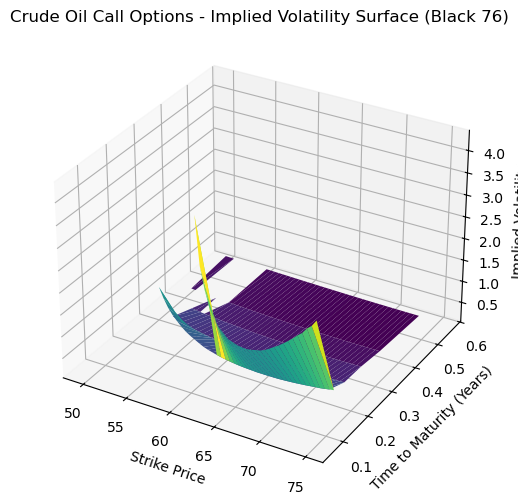

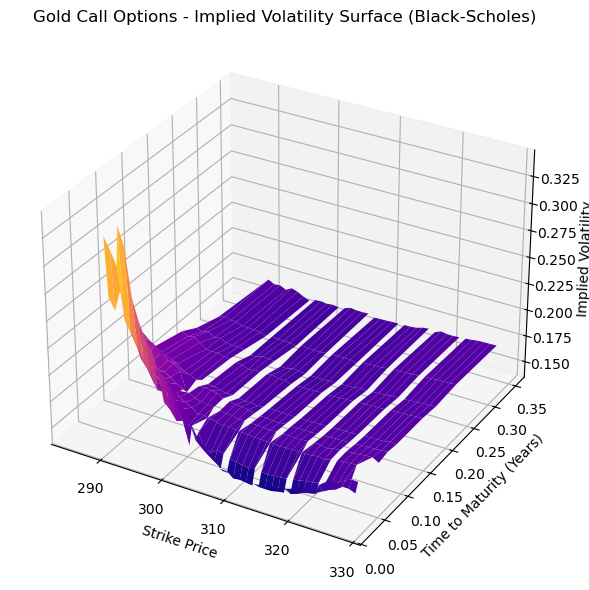

In [287]:
# Filter call options only for plotting IV surface
crude_calls = true_crude_oil_data[true_crude_oil_data['Type'].str.lower() == 'call'].copy()
gold_calls = true_spot_options_data[true_spot_options_data['Type'].str.lower() == 'call'].copy()

# Create pivot tables for surface plotting
crude_pivot = crude_calls.pivot_table(index='Strike', columns='Tau', values='Model IV')
gold_pivot = gold_calls.pivot_table(index='Strike', columns='Tau', values='Model IV')

# Create meshgrid for plotting
crude_strikes, crude_taus = np.meshgrid(crude_pivot.index, crude_pivot.columns)
crude_iv_surface = crude_pivot.values.T

gold_strikes, gold_taus = np.meshgrid(gold_pivot.index, gold_pivot.columns)
gold_iv_surface = gold_pivot.values.T

# Plot Crude Oil IV Surface
fig_crude = plt.figure(figsize=(12, 6))
ax1 = fig_crude.add_subplot(111, projection='3d')
ax1.plot_surface(crude_strikes, crude_taus, crude_iv_surface, cmap=cm.viridis)
ax1.set_title('Crude Oil Call Options - Implied Volatility Surface (Black 76)')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Time to Maturity (Years)')
ax1.set_zlabel('Implied Volatility')

# Plot Gold IV Surface
fig_gold = plt.figure(figsize=(12, 6))
ax2 = fig_gold.add_subplot(111, projection='3d')
ax2.plot_surface(gold_strikes, gold_taus, gold_iv_surface, cmap=cm.plasma)
ax2.set_title('Gold Call Options - Implied Volatility Surface (Black-Scholes)')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Time to Maturity (Years)')
ax2.set_zlabel('Implied Volatility')

plt.tight_layout()
plt.show()